<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#models.segmentation.fcn_resnet50" data-toc-modified-id="models.segmentation.fcn_resnet50-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>models.segmentation.fcn_resnet50</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [55]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch # 좌표값들을 시각화하기 위함 
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [57]:
batch_size = 8   # Mini-batch size
num_epochs = 100 # 20
learning_rate = 0.0001

In [58]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [59]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name: 
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name 
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats) # 종류
print('Number of categories:', nr_cats) # 종류
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


In [60]:
categories

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

- 한 종류의 클래스라도 annot가 여러 단위로 기록 되어있음.(마치 인스턴스 구분한 것처럼) 그래서 annotation개수가 image 개수보다 훨씬 많다.
- 그리고 하나의 픽셀에 여러 마스크가 있는 경우가 있음. 이런 경우 해당 픽셀에 GT mask로 어떤 마스크를 선택할지 기준을 정해야함. 
    - 작은 물체가 큰 물체에 포함이 되어있는 경우. (바운더리가 겹치는 경우)
    - 

왜 anns[0]은 segmentation len가 3개이고 anns[1]은 segmentation len 1인가?
둘다 image id= 0, category_id=8로 동일
- 다른 객체인가? **anns[0]과 anns[1]확인**

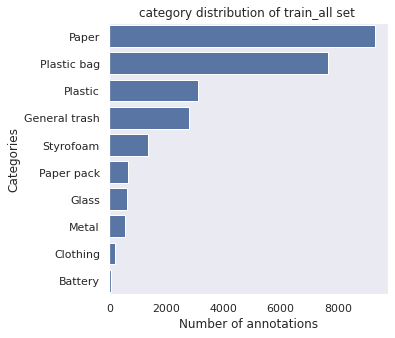

In [61]:
# Count annotations, 총 개수는 Number of annotations, 아직 annot가 구분된 기준 모름
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1 # 한개의 annot 단위마다 클래스 개수 셈

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False) #axis=0(index), asscending=False

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [62]:
cat_histogram

array([2782, 9311,  659,  562,  610, 3090, 1343, 7643,   63,  177])

In [63]:
# category labeling 
sorted_temp_df = df.sort_index() # index기준으로 정렬

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"]) # 변수명은 Categories, 첫 번째 데이터는 Background인 상황
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [64]:
sorted_df

Categories  Number of annotations
0       Backgroud                    NaN
1   General trash                 2782.0
2           Paper                 9311.0
3      Paper pack                  659.0
4           Metal                  562.0
5           Glass                  610.0
6         Plastic                 3090.0
7       Styrofoam                 1343.0
8     Plastic bag                 7643.0
9         Battery                   63.0
10       Clothing                  177.0

In [65]:
class_labels = {}
for i in range(sorted_df.shape[0]):
    class_labels[i] = sorted_df.Categories[i]
class_labels

{0: 'Backgroud',
 1: 'General trash',
 2: 'Paper',
 3: 'Paper pack',
 4: 'Metal',
 5: 'Glass',
 6: 'Plastic',
 7: 'Styrofoam',
 8: 'Plastic bag',
 9: 'Battery',
 10: 'Clothing'}

## 데이터 전처리 함수 정의 (Dataset)

In [66]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    '''classID가 주어졌을 때 class 이름 출력하는 함수, cats는 classID와 class 이름을 매핑'''
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir) # COCO(경로)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        '''
        index : 이미지의 id
        '''
        image_id = self.coco.getImgIds(imgIds=index) # selg.coco에서 getImgIds(이미지 index 필요)
        image_infos = self.coco.loadImgs(image_id)[0]
        ####------------------

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        

        # annotation
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=False) 
            # 수정전기준 :len(idx['segmentation'][0]) annotation좌표에 대해 오름차순 정렬
            # 수정후기준 : idx['area'] 기준으로 내림차순 정렬
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

- pxel value없이 바로 category_id를 사용해도 괜찮습니다. (기존 대회에서는 필요로 했었는데, 그때의 코드가 재사용되면서 남아 있는 부분이네요.)


# sort하는 이유
- data 제작 과정에서 annotaio이 이미지 픽셀에 중복되는 부분이 있었습니다. 때문에 mask가 제대로 매핑이 안되는 부분이 존재하였는데, 이를 해결하기 위해 순서를 고려하여 매핑하였습니다.


## Dataset 정의 및 DataLoader 할당

In [67]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [68]:
train_dataset[0]

(tensor([[[0.5098, 0.5137, 0.5137,  ..., 0.4784, 0.4824, 0.4863],
          [0.5059, 0.5059, 0.5137,  ..., 0.4784, 0.4824, 0.4863],
          [0.5020, 0.5059, 0.5098,  ..., 0.4784, 0.4824, 0.4824],
          ...,
          [0.5961, 0.5961, 0.5961,  ..., 0.3961, 0.3961, 0.3961],
          [0.6000, 0.6000, 0.6000,  ..., 0.3922, 0.3961, 0.3961],
          [0.6000, 0.6039, 0.6039,  ..., 0.3922, 0.3922, 0.3961]],
 
         [[0.4196, 0.4235, 0.4235,  ..., 0.3961, 0.4039, 0.4078],
          [0.4157, 0.4157, 0.4235,  ..., 0.3961, 0.4039, 0.4078],
          [0.4118, 0.4157, 0.4196,  ..., 0.3961, 0.4039, 0.4039],
          ...,
          [0.4549, 0.4549, 0.4549,  ..., 0.2235, 0.2235, 0.2235],
          [0.4588, 0.4588, 0.4588,  ..., 0.2196, 0.2235, 0.2235],
          [0.4588, 0.4627, 0.4627,  ..., 0.2196, 0.2196, 0.2235]],
 
         [[0.3490, 0.3529, 0.3529,  ..., 0.3137, 0.3098, 0.3137],
          [0.3451, 0.3451, 0.3529,  ..., 0.3137, 0.3098, 0.3137],
          [0.3412, 0.3451, 0.3490,  ...,

### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [69]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

name    r    g    b
0       Backgroud    0    0    0
1   General trash  192    0  128
2           Paper    0  128  192
3      Paper pack    0  128   64
4           Metal  128    0    0
5           Glass   64    0  128
6         Plastic   64    0  192
7       Styrofoam  192  128   64
8     Plastic bag  192  192  128
9         Battery   64   64  128
10       Clothing  128    0  192

In [70]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 2}, {8, 'Plastic bag'}]


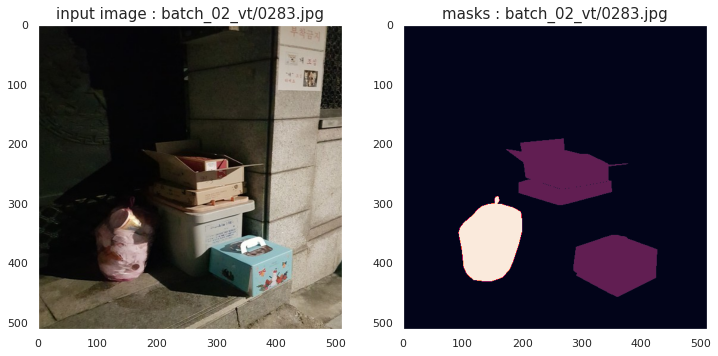

In [71]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


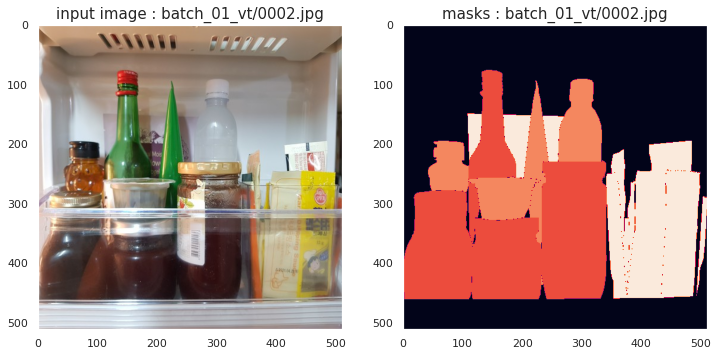

In [72]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


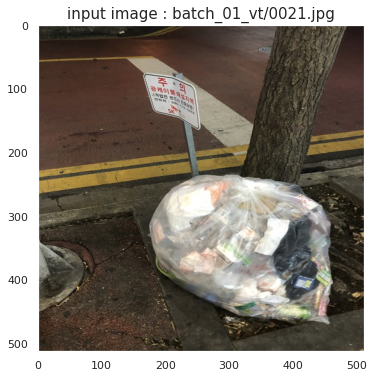

In [48]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### models.segmentation.fcn_resnet50

In [52]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-6_2z612s
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-6_2z612s


In [73]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn


#model = models.segmentation.fcn_resnet50(pretrained=True)

model = smp.Unet(
    encoder_name="tu-hrnet_w48",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=11,                      # model output channels (number of classes in your dataset)
)


# output class를 data set에 맞도록 수정
#model.classifier[4] = nn.Conv2d(512, 11, kernel_size=1)

KeyError: "Wrong encoder name `tu-hrnet_w48`, supported encoders: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d']"

In [ ]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512])
print(f"input shape : {x.shape}")
out = model(x) #model(x)['out']
print(f"output shape : {out.size()}")

## train, validation, test 함수 정의

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_mIoU = 0 #9999999
    
    for epoch in range(num_epochs):
        model.train()

        hist = np.zeros((n_class
                         , n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images) # collate_fn연관    
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images) #model(images)['out']
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
                wandb.log({'train_accuracy': round(acc, 4), 'train_loss': round(loss.item(),4), 'train_mIoU':round(mIoU,4)})
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            # avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            valid_mIoU = validation(epoch + 1, model, val_loader, criterion, device)
            if valid_mIoU > best_mIoU:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_mIoU = valid_mIoU
                save_model(model, saved_dir)

In [ ]:
class_labels = {}
for i in range(sorted_df.shape[0]):
    class_labels[i] = sorted_df.Categories[i]

In [ ]:
class_labels

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images) #model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class) # add_hist를 한 번만 커쳐서 image별 mo
            
            #wandb log
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
                  
        logging_img = []
        for img, output, mask in zip(images, outputs, masks):
           logging_img.append(wandb.Image(img, masks={
                    "predictions" : {
                    "mask_data" : output,
                    "class_labels" : class_labels, # 새로 정의
                                    },# prediction
                    "ground_truth" : {
                    "mask_data" : mask,
                    "class_labels" : class_labels
                                    } #ground_truth
                               }# mask
                        ))
        logging = {'images': logging_img,
                   'Val Loss': round(avrg_loss.item(), 4),
                  'Val Accuracy': round(acc, 4),
                   'Val mIoU' :round(mIoU, 4)
                  }
        for categories in IoU_by_class:
            logging.update(categories)
        wandb.log(logging)
        
        

    return mIoU # avrg_loss

In [ ]:
# wandb.log()
#   {"my_image_key" : wandb.Image(original_image, masks={
#     "predictions" : {
#         "mask_data" : prediction_mask,
#         "class_labels" : class_labels
#     },
#     "ground_truth" : {
#         "mask_data" : ground_truth_mask,
#         "class_labels" : class_labels
#     }
#    }
#   }
# )

   
   
   
# wandb.log(
#   {"my_image_key" : wandb.Image(original_image, masks={
#     "predictions" : {
#         "mask_data" : prediction_mask,
#         "class_labels" : class_labels
#     },
#     "ground_truth" : {
#         "mask_data" : ground_truth_mask,
#         "class_labels" : class_labels
#     }
#    }
#   }
# ))
#    wandb.log({'accuracy': train_acc, 'loss': train_loss})

## 모델 저장 함수 정의

In [ ]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='hrnet_w48_Unet_focalLoss(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, alpha=0.5, beta = 0.5, gamma=1):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [27]:
# Loss function 정의
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [28]:
import wandb
wandb.init(project="segmentation", name='Unet_hrnet_w48_focalLoss', entity='hongjourney')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hongjourney (use `wandb login --relogin` to force relogin)


In [31]:
# 1epoch 완료후 11시 19

In [29]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/85], Step [25/328],                         Loss: 6.115, mIoU: 0.0296
Epoch [1/85], Step [50/328],                         Loss: 6.1182, mIoU: 0.0421
Epoch [1/85], Step [75/328],                         Loss: 5.9474, mIoU: 0.0507
Epoch [1/85], Step [100/328],                         Loss: 6.0002, mIoU: 0.0582
Epoch [1/85], Step [125/328],                         Loss: 5.9533, mIoU: 0.0654
Epoch [1/85], Step [150/328],                         Loss: 5.973, mIoU: 0.0699
Epoch [1/85], Step [175/328],                         Loss: 5.9779, mIoU: 0.0752


Traceback (most recent call last):
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/connectio

KeyboardInterrupt: 

## 저장된 model 불러오기 (학습된 이후) 

In [51]:
# best model 저장된 경로
model_path = './saved/hrnet_w48_Unet_focalLoss(pretrained).pt' #'./saved/fcn_resnet50_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

RuntimeError: Error(s) in loading state_dict for UnetPlusPlus:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "decoder.blocks.x_0_0.conv1.0.weight", "decoder.blocks.x_0_0.conv1.1.weight", "decoder.blocks.x_0_0.conv1.1.bias", "decoder.blocks.x_0_0.conv1.1.running_mean", "decoder.blocks.x_0_0.conv1.1.running_var", "decoder.blocks.x_0_0.conv2.0.weight", "decoder.blocks.x_0_0.conv2.1.weight", "decoder.blocks.x_0_0.conv2.1.bias", "decoder.blocks.x_0_0.conv2.1.running_mean", "decoder.blocks.x_0_0.conv2.1.running_var", "decoder.blocks.x_0_1.conv1.0.weight", "decoder.blocks.x_0_1.conv1.1.weight", "decoder.blocks.x_0_1.conv1.1.bias", "decoder.blocks.x_0_1.conv1.1.running_mean", "decoder.blocks.x_0_1.conv1.1.running_var", "decoder.blocks.x_0_1.conv2.0.weight", "decoder.blocks.x_0_1.conv2.1.weight", "decoder.blocks.x_0_1.conv2.1.bias", "decoder.blocks.x_0_1.conv2.1.running_mean", "decoder.blocks.x_0_1.conv2.1.running_var", "decoder.blocks.x_1_1.conv1.0.weight", "decoder.blocks.x_1_1.conv1.1.weight", "decoder.blocks.x_1_1.conv1.1.bias", "decoder.blocks.x_1_1.conv1.1.running_mean", "decoder.blocks.x_1_1.conv1.1.running_var", "decoder.blocks.x_1_1.conv2.0.weight", "decoder.blocks.x_1_1.conv2.1.weight", "decoder.blocks.x_1_1.conv2.1.bias", "decoder.blocks.x_1_1.conv2.1.running_mean", "decoder.blocks.x_1_1.conv2.1.running_var", "decoder.blocks.x_0_2.conv1.0.weight", "decoder.blocks.x_0_2.conv1.1.weight", "decoder.blocks.x_0_2.conv1.1.bias", "decoder.blocks.x_0_2.conv1.1.running_mean", "decoder.blocks.x_0_2.conv1.1.running_var", "decoder.blocks.x_0_2.conv2.0.weight", "decoder.blocks.x_0_2.conv2.1.weight", "decoder.blocks.x_0_2.conv2.1.bias", "decoder.blocks.x_0_2.conv2.1.running_mean", "decoder.blocks.x_0_2.conv2.1.running_var", "decoder.blocks.x_1_2.conv1.0.weight", "decoder.blocks.x_1_2.conv1.1.weight", "decoder.blocks.x_1_2.conv1.1.bias", "decoder.blocks.x_1_2.conv1.1.running_mean", "decoder.blocks.x_1_2.conv1.1.running_var", "decoder.blocks.x_1_2.conv2.0.weight", "decoder.blocks.x_1_2.conv2.1.weight", "decoder.blocks.x_1_2.conv2.1.bias", "decoder.blocks.x_1_2.conv2.1.running_mean", "decoder.blocks.x_1_2.conv2.1.running_var", "decoder.blocks.x_2_2.conv1.0.weight", "decoder.blocks.x_2_2.conv1.1.weight", "decoder.blocks.x_2_2.conv1.1.bias", "decoder.blocks.x_2_2.conv1.1.running_mean", "decoder.blocks.x_2_2.conv1.1.running_var", "decoder.blocks.x_2_2.conv2.0.weight", "decoder.blocks.x_2_2.conv2.1.weight", "decoder.blocks.x_2_2.conv2.1.bias", "decoder.blocks.x_2_2.conv2.1.running_mean", "decoder.blocks.x_2_2.conv2.1.running_var", "decoder.blocks.x_0_3.conv1.0.weight", "decoder.blocks.x_0_3.conv1.1.weight", "decoder.blocks.x_0_3.conv1.1.bias", "decoder.blocks.x_0_3.conv1.1.running_mean", "decoder.blocks.x_0_3.conv1.1.running_var", "decoder.blocks.x_0_3.conv2.0.weight", "decoder.blocks.x_0_3.conv2.1.weight", "decoder.blocks.x_0_3.conv2.1.bias", "decoder.blocks.x_0_3.conv2.1.running_mean", "decoder.blocks.x_0_3.conv2.1.running_var", "decoder.blocks.x_1_3.conv1.0.weight", "decoder.blocks.x_1_3.conv1.1.weight", "decoder.blocks.x_1_3.conv1.1.bias", "decoder.blocks.x_1_3.conv1.1.running_mean", "decoder.blocks.x_1_3.conv1.1.running_var", "decoder.blocks.x_1_3.conv2.0.weight", "decoder.blocks.x_1_3.conv2.1.weight", "decoder.blocks.x_1_3.conv2.1.bias", "decoder.blocks.x_1_3.conv2.1.running_mean", "decoder.blocks.x_1_3.conv2.1.running_var", "decoder.blocks.x_2_3.conv1.0.weight", "decoder.blocks.x_2_3.conv1.1.weight", "decoder.blocks.x_2_3.conv1.1.bias", "decoder.blocks.x_2_3.conv1.1.running_mean", "decoder.blocks.x_2_3.conv1.1.running_var", "decoder.blocks.x_2_3.conv2.0.weight", "decoder.blocks.x_2_3.conv2.1.weight", "decoder.blocks.x_2_3.conv2.1.bias", "decoder.blocks.x_2_3.conv2.1.running_mean", "decoder.blocks.x_2_3.conv2.1.running_var", "decoder.blocks.x_3_3.conv1.0.weight", "decoder.blocks.x_3_3.conv1.1.weight", "decoder.blocks.x_3_3.conv1.1.bias", "decoder.blocks.x_3_3.conv1.1.running_mean", "decoder.blocks.x_3_3.conv1.1.running_var", "decoder.blocks.x_3_3.conv2.0.weight", "decoder.blocks.x_3_3.conv2.1.weight", "decoder.blocks.x_3_3.conv2.1.bias", "decoder.blocks.x_3_3.conv2.1.running_mean", "decoder.blocks.x_3_3.conv2.1.running_var", "decoder.blocks.x_0_4.conv1.0.weight", "decoder.blocks.x_0_4.conv1.1.weight", "decoder.blocks.x_0_4.conv1.1.bias", "decoder.blocks.x_0_4.conv1.1.running_mean", "decoder.blocks.x_0_4.conv1.1.running_var", "decoder.blocks.x_0_4.conv2.0.weight", "decoder.blocks.x_0_4.conv2.1.weight", "decoder.blocks.x_0_4.conv2.1.bias", "decoder.blocks.x_0_4.conv2.1.running_mean", "decoder.blocks.x_0_4.conv2.1.running_var". 
	Unexpected key(s) in state_dict: "encoder.model.conv1.weight", "encoder.model.bn1.weight", "encoder.model.bn1.bias", "encoder.model.bn1.running_mean", "encoder.model.bn1.running_var", "encoder.model.bn1.num_batches_tracked", "encoder.model.conv2.weight", "encoder.model.bn2.weight", "encoder.model.bn2.bias", "encoder.model.bn2.running_mean", "encoder.model.bn2.running_var", "encoder.model.bn2.num_batches_tracked", "encoder.model.layer1.0.conv1.weight", "encoder.model.layer1.0.bn1.weight", "encoder.model.layer1.0.bn1.bias", "encoder.model.layer1.0.bn1.running_mean", "encoder.model.layer1.0.bn1.running_var", "encoder.model.layer1.0.bn1.num_batches_tracked", "encoder.model.layer1.0.conv2.weight", "encoder.model.layer1.0.bn2.weight", "encoder.model.layer1.0.bn2.bias", "encoder.model.layer1.0.bn2.running_mean", "encoder.model.layer1.0.bn2.running_var", "encoder.model.layer1.0.bn2.num_batches_tracked", "encoder.model.layer1.0.conv3.weight", "encoder.model.layer1.0.bn3.weight", "encoder.model.layer1.0.bn3.bias", "encoder.model.layer1.0.bn3.running_mean", "encoder.model.layer1.0.bn3.running_var", "encoder.model.layer1.0.bn3.num_batches_tracked", "encoder.model.layer1.0.downsample.0.weight", "encoder.model.layer1.0.downsample.1.weight", "encoder.model.layer1.0.downsample.1.bias", "encoder.model.layer1.0.downsample.1.running_mean", "encoder.model.layer1.0.downsample.1.running_var", "encoder.model.layer1.0.downsample.1.num_batches_tracked", "encoder.model.layer1.1.conv1.weight", "encoder.model.layer1.1.bn1.weight", "encoder.model.layer1.1.bn1.bias", "encoder.model.layer1.1.bn1.running_mean", "encoder.model.layer1.1.bn1.running_var", "encoder.model.layer1.1.bn1.num_batches_tracked", "encoder.model.layer1.1.conv2.weight", "encoder.model.layer1.1.bn2.weight", "encoder.model.layer1.1.bn2.bias", "encoder.model.layer1.1.bn2.running_mean", "encoder.model.layer1.1.bn2.running_var", "encoder.model.layer1.1.bn2.num_batches_tracked", "encoder.model.layer1.1.conv3.weight", "encoder.model.layer1.1.bn3.weight", "encoder.model.layer1.1.bn3.bias", "encoder.model.layer1.1.bn3.running_mean", "encoder.model.layer1.1.bn3.running_var", "encoder.model.layer1.1.bn3.num_batches_tracked", "encoder.model.layer1.2.conv1.weight", "encoder.model.layer1.2.bn1.weight", "encoder.model.layer1.2.bn1.bias", "encoder.model.layer1.2.bn1.running_mean", "encoder.model.layer1.2.bn1.running_var", "encoder.model.layer1.2.bn1.num_batches_tracked", "encoder.model.layer1.2.conv2.weight", "encoder.model.layer1.2.bn2.weight", "encoder.model.layer1.2.bn2.bias", "encoder.model.layer1.2.bn2.running_mean", "encoder.model.layer1.2.bn2.running_var", "encoder.model.layer1.2.bn2.num_batches_tracked", "encoder.model.layer1.2.conv3.weight", "encoder.model.layer1.2.bn3.weight", "encoder.model.layer1.2.bn3.bias", "encoder.model.layer1.2.bn3.running_mean", "encoder.model.layer1.2.bn3.running_var", "encoder.model.layer1.2.bn3.num_batches_tracked", "encoder.model.layer1.3.conv1.weight", "encoder.model.layer1.3.bn1.weight", "encoder.model.layer1.3.bn1.bias", "encoder.model.layer1.3.bn1.running_mean", "encoder.model.layer1.3.bn1.running_var", "encoder.model.layer1.3.bn1.num_batches_tracked", "encoder.model.layer1.3.conv2.weight", "encoder.model.layer1.3.bn2.weight", "encoder.model.layer1.3.bn2.bias", "encoder.model.layer1.3.bn2.running_mean", "encoder.model.layer1.3.bn2.running_var", "encoder.model.layer1.3.bn2.num_batches_tracked", "encoder.model.layer1.3.conv3.weight", "encoder.model.layer1.3.bn3.weight", "encoder.model.layer1.3.bn3.bias", "encoder.model.layer1.3.bn3.running_mean", "encoder.model.layer1.3.bn3.running_var", "encoder.model.layer1.3.bn3.num_batches_tracked", "encoder.model.transition1.0.0.weight", "encoder.model.transition1.0.1.weight", "encoder.model.transition1.0.1.bias", "encoder.model.transition1.0.1.running_mean", "encoder.model.transition1.0.1.running_var", "encoder.model.transition1.0.1.num_batches_tracked", "encoder.model.transition1.1.0.0.weight", "encoder.model.transition1.1.0.1.weight", "encoder.model.transition1.1.0.1.bias", "encoder.model.transition1.1.0.1.running_mean", "encoder.model.transition1.1.0.1.running_var", "encoder.model.transition1.1.0.1.num_batches_tracked", "encoder.model.stage2.0.branches.0.0.conv1.weight", "encoder.model.stage2.0.branches.0.0.bn1.weight", "encoder.model.stage2.0.branches.0.0.bn1.bias", "encoder.model.stage2.0.branches.0.0.bn1.running_mean", "encoder.model.stage2.0.branches.0.0.bn1.running_var", "encoder.model.stage2.0.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.0.0.conv2.weight", "encoder.model.stage2.0.branches.0.0.bn2.weight", "encoder.model.stage2.0.branches.0.0.bn2.bias", "encoder.model.stage2.0.branches.0.0.bn2.running_mean", "encoder.model.stage2.0.branches.0.0.bn2.running_var", "encoder.model.stage2.0.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.0.1.conv1.weight", "encoder.model.stage2.0.branches.0.1.bn1.weight", "encoder.model.stage2.0.branches.0.1.bn1.bias", "encoder.model.stage2.0.branches.0.1.bn1.running_mean", "encoder.model.stage2.0.branches.0.1.bn1.running_var", "encoder.model.stage2.0.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.0.1.conv2.weight", "encoder.model.stage2.0.branches.0.1.bn2.weight", "encoder.model.stage2.0.branches.0.1.bn2.bias", "encoder.model.stage2.0.branches.0.1.bn2.running_mean", "encoder.model.stage2.0.branches.0.1.bn2.running_var", "encoder.model.stage2.0.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.0.2.conv1.weight", "encoder.model.stage2.0.branches.0.2.bn1.weight", "encoder.model.stage2.0.branches.0.2.bn1.bias", "encoder.model.stage2.0.branches.0.2.bn1.running_mean", "encoder.model.stage2.0.branches.0.2.bn1.running_var", "encoder.model.stage2.0.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.0.2.conv2.weight", "encoder.model.stage2.0.branches.0.2.bn2.weight", "encoder.model.stage2.0.branches.0.2.bn2.bias", "encoder.model.stage2.0.branches.0.2.bn2.running_mean", "encoder.model.stage2.0.branches.0.2.bn2.running_var", "encoder.model.stage2.0.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.0.3.conv1.weight", "encoder.model.stage2.0.branches.0.3.bn1.weight", "encoder.model.stage2.0.branches.0.3.bn1.bias", "encoder.model.stage2.0.branches.0.3.bn1.running_mean", "encoder.model.stage2.0.branches.0.3.bn1.running_var", "encoder.model.stage2.0.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.0.3.conv2.weight", "encoder.model.stage2.0.branches.0.3.bn2.weight", "encoder.model.stage2.0.branches.0.3.bn2.bias", "encoder.model.stage2.0.branches.0.3.bn2.running_mean", "encoder.model.stage2.0.branches.0.3.bn2.running_var", "encoder.model.stage2.0.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.1.0.conv1.weight", "encoder.model.stage2.0.branches.1.0.bn1.weight", "encoder.model.stage2.0.branches.1.0.bn1.bias", "encoder.model.stage2.0.branches.1.0.bn1.running_mean", "encoder.model.stage2.0.branches.1.0.bn1.running_var", "encoder.model.stage2.0.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.1.0.conv2.weight", "encoder.model.stage2.0.branches.1.0.bn2.weight", "encoder.model.stage2.0.branches.1.0.bn2.bias", "encoder.model.stage2.0.branches.1.0.bn2.running_mean", "encoder.model.stage2.0.branches.1.0.bn2.running_var", "encoder.model.stage2.0.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.1.1.conv1.weight", "encoder.model.stage2.0.branches.1.1.bn1.weight", "encoder.model.stage2.0.branches.1.1.bn1.bias", "encoder.model.stage2.0.branches.1.1.bn1.running_mean", "encoder.model.stage2.0.branches.1.1.bn1.running_var", "encoder.model.stage2.0.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.1.1.conv2.weight", "encoder.model.stage2.0.branches.1.1.bn2.weight", "encoder.model.stage2.0.branches.1.1.bn2.bias", "encoder.model.stage2.0.branches.1.1.bn2.running_mean", "encoder.model.stage2.0.branches.1.1.bn2.running_var", "encoder.model.stage2.0.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.1.2.conv1.weight", "encoder.model.stage2.0.branches.1.2.bn1.weight", "encoder.model.stage2.0.branches.1.2.bn1.bias", "encoder.model.stage2.0.branches.1.2.bn1.running_mean", "encoder.model.stage2.0.branches.1.2.bn1.running_var", "encoder.model.stage2.0.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.1.2.conv2.weight", "encoder.model.stage2.0.branches.1.2.bn2.weight", "encoder.model.stage2.0.branches.1.2.bn2.bias", "encoder.model.stage2.0.branches.1.2.bn2.running_mean", "encoder.model.stage2.0.branches.1.2.bn2.running_var", "encoder.model.stage2.0.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage2.0.branches.1.3.conv1.weight", "encoder.model.stage2.0.branches.1.3.bn1.weight", "encoder.model.stage2.0.branches.1.3.bn1.bias", "encoder.model.stage2.0.branches.1.3.bn1.running_mean", "encoder.model.stage2.0.branches.1.3.bn1.running_var", "encoder.model.stage2.0.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage2.0.branches.1.3.conv2.weight", "encoder.model.stage2.0.branches.1.3.bn2.weight", "encoder.model.stage2.0.branches.1.3.bn2.bias", "encoder.model.stage2.0.branches.1.3.bn2.running_mean", "encoder.model.stage2.0.branches.1.3.bn2.running_var", "encoder.model.stage2.0.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage2.0.fuse_layers.0.1.0.weight", "encoder.model.stage2.0.fuse_layers.0.1.1.weight", "encoder.model.stage2.0.fuse_layers.0.1.1.bias", "encoder.model.stage2.0.fuse_layers.0.1.1.running_mean", "encoder.model.stage2.0.fuse_layers.0.1.1.running_var", "encoder.model.stage2.0.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage2.0.fuse_layers.1.0.0.0.weight", "encoder.model.stage2.0.fuse_layers.1.0.0.1.weight", "encoder.model.stage2.0.fuse_layers.1.0.0.1.bias", "encoder.model.stage2.0.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage2.0.fuse_layers.1.0.0.1.running_var", "encoder.model.stage2.0.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.transition2.2.0.0.weight", "encoder.model.transition2.2.0.1.weight", "encoder.model.transition2.2.0.1.bias", "encoder.model.transition2.2.0.1.running_mean", "encoder.model.transition2.2.0.1.running_var", "encoder.model.transition2.2.0.1.num_batches_tracked", "encoder.model.stage3.0.branches.0.0.conv1.weight", "encoder.model.stage3.0.branches.0.0.bn1.weight", "encoder.model.stage3.0.branches.0.0.bn1.bias", "encoder.model.stage3.0.branches.0.0.bn1.running_mean", "encoder.model.stage3.0.branches.0.0.bn1.running_var", "encoder.model.stage3.0.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.0.0.conv2.weight", "encoder.model.stage3.0.branches.0.0.bn2.weight", "encoder.model.stage3.0.branches.0.0.bn2.bias", "encoder.model.stage3.0.branches.0.0.bn2.running_mean", "encoder.model.stage3.0.branches.0.0.bn2.running_var", "encoder.model.stage3.0.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.0.1.conv1.weight", "encoder.model.stage3.0.branches.0.1.bn1.weight", "encoder.model.stage3.0.branches.0.1.bn1.bias", "encoder.model.stage3.0.branches.0.1.bn1.running_mean", "encoder.model.stage3.0.branches.0.1.bn1.running_var", "encoder.model.stage3.0.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.0.1.conv2.weight", "encoder.model.stage3.0.branches.0.1.bn2.weight", "encoder.model.stage3.0.branches.0.1.bn2.bias", "encoder.model.stage3.0.branches.0.1.bn2.running_mean", "encoder.model.stage3.0.branches.0.1.bn2.running_var", "encoder.model.stage3.0.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.0.2.conv1.weight", "encoder.model.stage3.0.branches.0.2.bn1.weight", "encoder.model.stage3.0.branches.0.2.bn1.bias", "encoder.model.stage3.0.branches.0.2.bn1.running_mean", "encoder.model.stage3.0.branches.0.2.bn1.running_var", "encoder.model.stage3.0.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.0.2.conv2.weight", "encoder.model.stage3.0.branches.0.2.bn2.weight", "encoder.model.stage3.0.branches.0.2.bn2.bias", "encoder.model.stage3.0.branches.0.2.bn2.running_mean", "encoder.model.stage3.0.branches.0.2.bn2.running_var", "encoder.model.stage3.0.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.0.3.conv1.weight", "encoder.model.stage3.0.branches.0.3.bn1.weight", "encoder.model.stage3.0.branches.0.3.bn1.bias", "encoder.model.stage3.0.branches.0.3.bn1.running_mean", "encoder.model.stage3.0.branches.0.3.bn1.running_var", "encoder.model.stage3.0.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.0.3.conv2.weight", "encoder.model.stage3.0.branches.0.3.bn2.weight", "encoder.model.stage3.0.branches.0.3.bn2.bias", "encoder.model.stage3.0.branches.0.3.bn2.running_mean", "encoder.model.stage3.0.branches.0.3.bn2.running_var", "encoder.model.stage3.0.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.1.0.conv1.weight", "encoder.model.stage3.0.branches.1.0.bn1.weight", "encoder.model.stage3.0.branches.1.0.bn1.bias", "encoder.model.stage3.0.branches.1.0.bn1.running_mean", "encoder.model.stage3.0.branches.1.0.bn1.running_var", "encoder.model.stage3.0.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.1.0.conv2.weight", "encoder.model.stage3.0.branches.1.0.bn2.weight", "encoder.model.stage3.0.branches.1.0.bn2.bias", "encoder.model.stage3.0.branches.1.0.bn2.running_mean", "encoder.model.stage3.0.branches.1.0.bn2.running_var", "encoder.model.stage3.0.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.1.1.conv1.weight", "encoder.model.stage3.0.branches.1.1.bn1.weight", "encoder.model.stage3.0.branches.1.1.bn1.bias", "encoder.model.stage3.0.branches.1.1.bn1.running_mean", "encoder.model.stage3.0.branches.1.1.bn1.running_var", "encoder.model.stage3.0.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.1.1.conv2.weight", "encoder.model.stage3.0.branches.1.1.bn2.weight", "encoder.model.stage3.0.branches.1.1.bn2.bias", "encoder.model.stage3.0.branches.1.1.bn2.running_mean", "encoder.model.stage3.0.branches.1.1.bn2.running_var", "encoder.model.stage3.0.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.1.2.conv1.weight", "encoder.model.stage3.0.branches.1.2.bn1.weight", "encoder.model.stage3.0.branches.1.2.bn1.bias", "encoder.model.stage3.0.branches.1.2.bn1.running_mean", "encoder.model.stage3.0.branches.1.2.bn1.running_var", "encoder.model.stage3.0.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.1.2.conv2.weight", "encoder.model.stage3.0.branches.1.2.bn2.weight", "encoder.model.stage3.0.branches.1.2.bn2.bias", "encoder.model.stage3.0.branches.1.2.bn2.running_mean", "encoder.model.stage3.0.branches.1.2.bn2.running_var", "encoder.model.stage3.0.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.1.3.conv1.weight", "encoder.model.stage3.0.branches.1.3.bn1.weight", "encoder.model.stage3.0.branches.1.3.bn1.bias", "encoder.model.stage3.0.branches.1.3.bn1.running_mean", "encoder.model.stage3.0.branches.1.3.bn1.running_var", "encoder.model.stage3.0.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.1.3.conv2.weight", "encoder.model.stage3.0.branches.1.3.bn2.weight", "encoder.model.stage3.0.branches.1.3.bn2.bias", "encoder.model.stage3.0.branches.1.3.bn2.running_mean", "encoder.model.stage3.0.branches.1.3.bn2.running_var", "encoder.model.stage3.0.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.2.0.conv1.weight", "encoder.model.stage3.0.branches.2.0.bn1.weight", "encoder.model.stage3.0.branches.2.0.bn1.bias", "encoder.model.stage3.0.branches.2.0.bn1.running_mean", "encoder.model.stage3.0.branches.2.0.bn1.running_var", "encoder.model.stage3.0.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.2.0.conv2.weight", "encoder.model.stage3.0.branches.2.0.bn2.weight", "encoder.model.stage3.0.branches.2.0.bn2.bias", "encoder.model.stage3.0.branches.2.0.bn2.running_mean", "encoder.model.stage3.0.branches.2.0.bn2.running_var", "encoder.model.stage3.0.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.2.1.conv1.weight", "encoder.model.stage3.0.branches.2.1.bn1.weight", "encoder.model.stage3.0.branches.2.1.bn1.bias", "encoder.model.stage3.0.branches.2.1.bn1.running_mean", "encoder.model.stage3.0.branches.2.1.bn1.running_var", "encoder.model.stage3.0.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.2.1.conv2.weight", "encoder.model.stage3.0.branches.2.1.bn2.weight", "encoder.model.stage3.0.branches.2.1.bn2.bias", "encoder.model.stage3.0.branches.2.1.bn2.running_mean", "encoder.model.stage3.0.branches.2.1.bn2.running_var", "encoder.model.stage3.0.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.2.2.conv1.weight", "encoder.model.stage3.0.branches.2.2.bn1.weight", "encoder.model.stage3.0.branches.2.2.bn1.bias", "encoder.model.stage3.0.branches.2.2.bn1.running_mean", "encoder.model.stage3.0.branches.2.2.bn1.running_var", "encoder.model.stage3.0.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.2.2.conv2.weight", "encoder.model.stage3.0.branches.2.2.bn2.weight", "encoder.model.stage3.0.branches.2.2.bn2.bias", "encoder.model.stage3.0.branches.2.2.bn2.running_mean", "encoder.model.stage3.0.branches.2.2.bn2.running_var", "encoder.model.stage3.0.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage3.0.branches.2.3.conv1.weight", "encoder.model.stage3.0.branches.2.3.bn1.weight", "encoder.model.stage3.0.branches.2.3.bn1.bias", "encoder.model.stage3.0.branches.2.3.bn1.running_mean", "encoder.model.stage3.0.branches.2.3.bn1.running_var", "encoder.model.stage3.0.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage3.0.branches.2.3.conv2.weight", "encoder.model.stage3.0.branches.2.3.bn2.weight", "encoder.model.stage3.0.branches.2.3.bn2.bias", "encoder.model.stage3.0.branches.2.3.bn2.running_mean", "encoder.model.stage3.0.branches.2.3.bn2.running_var", "encoder.model.stage3.0.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.0.1.0.weight", "encoder.model.stage3.0.fuse_layers.0.1.1.weight", "encoder.model.stage3.0.fuse_layers.0.1.1.bias", "encoder.model.stage3.0.fuse_layers.0.1.1.running_mean", "encoder.model.stage3.0.fuse_layers.0.1.1.running_var", "encoder.model.stage3.0.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.0.2.0.weight", "encoder.model.stage3.0.fuse_layers.0.2.1.weight", "encoder.model.stage3.0.fuse_layers.0.2.1.bias", "encoder.model.stage3.0.fuse_layers.0.2.1.running_mean", "encoder.model.stage3.0.fuse_layers.0.2.1.running_var", "encoder.model.stage3.0.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.1.0.0.0.weight", "encoder.model.stage3.0.fuse_layers.1.0.0.1.weight", "encoder.model.stage3.0.fuse_layers.1.0.0.1.bias", "encoder.model.stage3.0.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage3.0.fuse_layers.1.0.0.1.running_var", "encoder.model.stage3.0.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.1.2.0.weight", "encoder.model.stage3.0.fuse_layers.1.2.1.weight", "encoder.model.stage3.0.fuse_layers.1.2.1.bias", "encoder.model.stage3.0.fuse_layers.1.2.1.running_mean", "encoder.model.stage3.0.fuse_layers.1.2.1.running_var", "encoder.model.stage3.0.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.2.0.0.0.weight", "encoder.model.stage3.0.fuse_layers.2.0.0.1.weight", "encoder.model.stage3.0.fuse_layers.2.0.0.1.bias", "encoder.model.stage3.0.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage3.0.fuse_layers.2.0.0.1.running_var", "encoder.model.stage3.0.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.2.0.1.0.weight", "encoder.model.stage3.0.fuse_layers.2.0.1.1.weight", "encoder.model.stage3.0.fuse_layers.2.0.1.1.bias", "encoder.model.stage3.0.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage3.0.fuse_layers.2.0.1.1.running_var", "encoder.model.stage3.0.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage3.0.fuse_layers.2.1.0.0.weight", "encoder.model.stage3.0.fuse_layers.2.1.0.1.weight", "encoder.model.stage3.0.fuse_layers.2.1.0.1.bias", "encoder.model.stage3.0.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage3.0.fuse_layers.2.1.0.1.running_var", "encoder.model.stage3.0.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage3.1.branches.0.0.conv1.weight", "encoder.model.stage3.1.branches.0.0.bn1.weight", "encoder.model.stage3.1.branches.0.0.bn1.bias", "encoder.model.stage3.1.branches.0.0.bn1.running_mean", "encoder.model.stage3.1.branches.0.0.bn1.running_var", "encoder.model.stage3.1.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.0.0.conv2.weight", "encoder.model.stage3.1.branches.0.0.bn2.weight", "encoder.model.stage3.1.branches.0.0.bn2.bias", "encoder.model.stage3.1.branches.0.0.bn2.running_mean", "encoder.model.stage3.1.branches.0.0.bn2.running_var", "encoder.model.stage3.1.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.0.1.conv1.weight", "encoder.model.stage3.1.branches.0.1.bn1.weight", "encoder.model.stage3.1.branches.0.1.bn1.bias", "encoder.model.stage3.1.branches.0.1.bn1.running_mean", "encoder.model.stage3.1.branches.0.1.bn1.running_var", "encoder.model.stage3.1.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.0.1.conv2.weight", "encoder.model.stage3.1.branches.0.1.bn2.weight", "encoder.model.stage3.1.branches.0.1.bn2.bias", "encoder.model.stage3.1.branches.0.1.bn2.running_mean", "encoder.model.stage3.1.branches.0.1.bn2.running_var", "encoder.model.stage3.1.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.0.2.conv1.weight", "encoder.model.stage3.1.branches.0.2.bn1.weight", "encoder.model.stage3.1.branches.0.2.bn1.bias", "encoder.model.stage3.1.branches.0.2.bn1.running_mean", "encoder.model.stage3.1.branches.0.2.bn1.running_var", "encoder.model.stage3.1.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.0.2.conv2.weight", "encoder.model.stage3.1.branches.0.2.bn2.weight", "encoder.model.stage3.1.branches.0.2.bn2.bias", "encoder.model.stage3.1.branches.0.2.bn2.running_mean", "encoder.model.stage3.1.branches.0.2.bn2.running_var", "encoder.model.stage3.1.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.0.3.conv1.weight", "encoder.model.stage3.1.branches.0.3.bn1.weight", "encoder.model.stage3.1.branches.0.3.bn1.bias", "encoder.model.stage3.1.branches.0.3.bn1.running_mean", "encoder.model.stage3.1.branches.0.3.bn1.running_var", "encoder.model.stage3.1.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.0.3.conv2.weight", "encoder.model.stage3.1.branches.0.3.bn2.weight", "encoder.model.stage3.1.branches.0.3.bn2.bias", "encoder.model.stage3.1.branches.0.3.bn2.running_mean", "encoder.model.stage3.1.branches.0.3.bn2.running_var", "encoder.model.stage3.1.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.1.0.conv1.weight", "encoder.model.stage3.1.branches.1.0.bn1.weight", "encoder.model.stage3.1.branches.1.0.bn1.bias", "encoder.model.stage3.1.branches.1.0.bn1.running_mean", "encoder.model.stage3.1.branches.1.0.bn1.running_var", "encoder.model.stage3.1.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.1.0.conv2.weight", "encoder.model.stage3.1.branches.1.0.bn2.weight", "encoder.model.stage3.1.branches.1.0.bn2.bias", "encoder.model.stage3.1.branches.1.0.bn2.running_mean", "encoder.model.stage3.1.branches.1.0.bn2.running_var", "encoder.model.stage3.1.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.1.1.conv1.weight", "encoder.model.stage3.1.branches.1.1.bn1.weight", "encoder.model.stage3.1.branches.1.1.bn1.bias", "encoder.model.stage3.1.branches.1.1.bn1.running_mean", "encoder.model.stage3.1.branches.1.1.bn1.running_var", "encoder.model.stage3.1.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.1.1.conv2.weight", "encoder.model.stage3.1.branches.1.1.bn2.weight", "encoder.model.stage3.1.branches.1.1.bn2.bias", "encoder.model.stage3.1.branches.1.1.bn2.running_mean", "encoder.model.stage3.1.branches.1.1.bn2.running_var", "encoder.model.stage3.1.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.1.2.conv1.weight", "encoder.model.stage3.1.branches.1.2.bn1.weight", "encoder.model.stage3.1.branches.1.2.bn1.bias", "encoder.model.stage3.1.branches.1.2.bn1.running_mean", "encoder.model.stage3.1.branches.1.2.bn1.running_var", "encoder.model.stage3.1.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.1.2.conv2.weight", "encoder.model.stage3.1.branches.1.2.bn2.weight", "encoder.model.stage3.1.branches.1.2.bn2.bias", "encoder.model.stage3.1.branches.1.2.bn2.running_mean", "encoder.model.stage3.1.branches.1.2.bn2.running_var", "encoder.model.stage3.1.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.1.3.conv1.weight", "encoder.model.stage3.1.branches.1.3.bn1.weight", "encoder.model.stage3.1.branches.1.3.bn1.bias", "encoder.model.stage3.1.branches.1.3.bn1.running_mean", "encoder.model.stage3.1.branches.1.3.bn1.running_var", "encoder.model.stage3.1.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.1.3.conv2.weight", "encoder.model.stage3.1.branches.1.3.bn2.weight", "encoder.model.stage3.1.branches.1.3.bn2.bias", "encoder.model.stage3.1.branches.1.3.bn2.running_mean", "encoder.model.stage3.1.branches.1.3.bn2.running_var", "encoder.model.stage3.1.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.2.0.conv1.weight", "encoder.model.stage3.1.branches.2.0.bn1.weight", "encoder.model.stage3.1.branches.2.0.bn1.bias", "encoder.model.stage3.1.branches.2.0.bn1.running_mean", "encoder.model.stage3.1.branches.2.0.bn1.running_var", "encoder.model.stage3.1.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.2.0.conv2.weight", "encoder.model.stage3.1.branches.2.0.bn2.weight", "encoder.model.stage3.1.branches.2.0.bn2.bias", "encoder.model.stage3.1.branches.2.0.bn2.running_mean", "encoder.model.stage3.1.branches.2.0.bn2.running_var", "encoder.model.stage3.1.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.2.1.conv1.weight", "encoder.model.stage3.1.branches.2.1.bn1.weight", "encoder.model.stage3.1.branches.2.1.bn1.bias", "encoder.model.stage3.1.branches.2.1.bn1.running_mean", "encoder.model.stage3.1.branches.2.1.bn1.running_var", "encoder.model.stage3.1.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.2.1.conv2.weight", "encoder.model.stage3.1.branches.2.1.bn2.weight", "encoder.model.stage3.1.branches.2.1.bn2.bias", "encoder.model.stage3.1.branches.2.1.bn2.running_mean", "encoder.model.stage3.1.branches.2.1.bn2.running_var", "encoder.model.stage3.1.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.2.2.conv1.weight", "encoder.model.stage3.1.branches.2.2.bn1.weight", "encoder.model.stage3.1.branches.2.2.bn1.bias", "encoder.model.stage3.1.branches.2.2.bn1.running_mean", "encoder.model.stage3.1.branches.2.2.bn1.running_var", "encoder.model.stage3.1.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.2.2.conv2.weight", "encoder.model.stage3.1.branches.2.2.bn2.weight", "encoder.model.stage3.1.branches.2.2.bn2.bias", "encoder.model.stage3.1.branches.2.2.bn2.running_mean", "encoder.model.stage3.1.branches.2.2.bn2.running_var", "encoder.model.stage3.1.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage3.1.branches.2.3.conv1.weight", "encoder.model.stage3.1.branches.2.3.bn1.weight", "encoder.model.stage3.1.branches.2.3.bn1.bias", "encoder.model.stage3.1.branches.2.3.bn1.running_mean", "encoder.model.stage3.1.branches.2.3.bn1.running_var", "encoder.model.stage3.1.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage3.1.branches.2.3.conv2.weight", "encoder.model.stage3.1.branches.2.3.bn2.weight", "encoder.model.stage3.1.branches.2.3.bn2.bias", "encoder.model.stage3.1.branches.2.3.bn2.running_mean", "encoder.model.stage3.1.branches.2.3.bn2.running_var", "encoder.model.stage3.1.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.0.1.0.weight", "encoder.model.stage3.1.fuse_layers.0.1.1.weight", "encoder.model.stage3.1.fuse_layers.0.1.1.bias", "encoder.model.stage3.1.fuse_layers.0.1.1.running_mean", "encoder.model.stage3.1.fuse_layers.0.1.1.running_var", "encoder.model.stage3.1.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.0.2.0.weight", "encoder.model.stage3.1.fuse_layers.0.2.1.weight", "encoder.model.stage3.1.fuse_layers.0.2.1.bias", "encoder.model.stage3.1.fuse_layers.0.2.1.running_mean", "encoder.model.stage3.1.fuse_layers.0.2.1.running_var", "encoder.model.stage3.1.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.1.0.0.0.weight", "encoder.model.stage3.1.fuse_layers.1.0.0.1.weight", "encoder.model.stage3.1.fuse_layers.1.0.0.1.bias", "encoder.model.stage3.1.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage3.1.fuse_layers.1.0.0.1.running_var", "encoder.model.stage3.1.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.1.2.0.weight", "encoder.model.stage3.1.fuse_layers.1.2.1.weight", "encoder.model.stage3.1.fuse_layers.1.2.1.bias", "encoder.model.stage3.1.fuse_layers.1.2.1.running_mean", "encoder.model.stage3.1.fuse_layers.1.2.1.running_var", "encoder.model.stage3.1.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.2.0.0.0.weight", "encoder.model.stage3.1.fuse_layers.2.0.0.1.weight", "encoder.model.stage3.1.fuse_layers.2.0.0.1.bias", "encoder.model.stage3.1.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage3.1.fuse_layers.2.0.0.1.running_var", "encoder.model.stage3.1.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.2.0.1.0.weight", "encoder.model.stage3.1.fuse_layers.2.0.1.1.weight", "encoder.model.stage3.1.fuse_layers.2.0.1.1.bias", "encoder.model.stage3.1.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage3.1.fuse_layers.2.0.1.1.running_var", "encoder.model.stage3.1.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage3.1.fuse_layers.2.1.0.0.weight", "encoder.model.stage3.1.fuse_layers.2.1.0.1.weight", "encoder.model.stage3.1.fuse_layers.2.1.0.1.bias", "encoder.model.stage3.1.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage3.1.fuse_layers.2.1.0.1.running_var", "encoder.model.stage3.1.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage3.2.branches.0.0.conv1.weight", "encoder.model.stage3.2.branches.0.0.bn1.weight", "encoder.model.stage3.2.branches.0.0.bn1.bias", "encoder.model.stage3.2.branches.0.0.bn1.running_mean", "encoder.model.stage3.2.branches.0.0.bn1.running_var", "encoder.model.stage3.2.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.0.0.conv2.weight", "encoder.model.stage3.2.branches.0.0.bn2.weight", "encoder.model.stage3.2.branches.0.0.bn2.bias", "encoder.model.stage3.2.branches.0.0.bn2.running_mean", "encoder.model.stage3.2.branches.0.0.bn2.running_var", "encoder.model.stage3.2.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.0.1.conv1.weight", "encoder.model.stage3.2.branches.0.1.bn1.weight", "encoder.model.stage3.2.branches.0.1.bn1.bias", "encoder.model.stage3.2.branches.0.1.bn1.running_mean", "encoder.model.stage3.2.branches.0.1.bn1.running_var", "encoder.model.stage3.2.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.0.1.conv2.weight", "encoder.model.stage3.2.branches.0.1.bn2.weight", "encoder.model.stage3.2.branches.0.1.bn2.bias", "encoder.model.stage3.2.branches.0.1.bn2.running_mean", "encoder.model.stage3.2.branches.0.1.bn2.running_var", "encoder.model.stage3.2.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.0.2.conv1.weight", "encoder.model.stage3.2.branches.0.2.bn1.weight", "encoder.model.stage3.2.branches.0.2.bn1.bias", "encoder.model.stage3.2.branches.0.2.bn1.running_mean", "encoder.model.stage3.2.branches.0.2.bn1.running_var", "encoder.model.stage3.2.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.0.2.conv2.weight", "encoder.model.stage3.2.branches.0.2.bn2.weight", "encoder.model.stage3.2.branches.0.2.bn2.bias", "encoder.model.stage3.2.branches.0.2.bn2.running_mean", "encoder.model.stage3.2.branches.0.2.bn2.running_var", "encoder.model.stage3.2.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.0.3.conv1.weight", "encoder.model.stage3.2.branches.0.3.bn1.weight", "encoder.model.stage3.2.branches.0.3.bn1.bias", "encoder.model.stage3.2.branches.0.3.bn1.running_mean", "encoder.model.stage3.2.branches.0.3.bn1.running_var", "encoder.model.stage3.2.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.0.3.conv2.weight", "encoder.model.stage3.2.branches.0.3.bn2.weight", "encoder.model.stage3.2.branches.0.3.bn2.bias", "encoder.model.stage3.2.branches.0.3.bn2.running_mean", "encoder.model.stage3.2.branches.0.3.bn2.running_var", "encoder.model.stage3.2.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.1.0.conv1.weight", "encoder.model.stage3.2.branches.1.0.bn1.weight", "encoder.model.stage3.2.branches.1.0.bn1.bias", "encoder.model.stage3.2.branches.1.0.bn1.running_mean", "encoder.model.stage3.2.branches.1.0.bn1.running_var", "encoder.model.stage3.2.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.1.0.conv2.weight", "encoder.model.stage3.2.branches.1.0.bn2.weight", "encoder.model.stage3.2.branches.1.0.bn2.bias", "encoder.model.stage3.2.branches.1.0.bn2.running_mean", "encoder.model.stage3.2.branches.1.0.bn2.running_var", "encoder.model.stage3.2.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.1.1.conv1.weight", "encoder.model.stage3.2.branches.1.1.bn1.weight", "encoder.model.stage3.2.branches.1.1.bn1.bias", "encoder.model.stage3.2.branches.1.1.bn1.running_mean", "encoder.model.stage3.2.branches.1.1.bn1.running_var", "encoder.model.stage3.2.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.1.1.conv2.weight", "encoder.model.stage3.2.branches.1.1.bn2.weight", "encoder.model.stage3.2.branches.1.1.bn2.bias", "encoder.model.stage3.2.branches.1.1.bn2.running_mean", "encoder.model.stage3.2.branches.1.1.bn2.running_var", "encoder.model.stage3.2.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.1.2.conv1.weight", "encoder.model.stage3.2.branches.1.2.bn1.weight", "encoder.model.stage3.2.branches.1.2.bn1.bias", "encoder.model.stage3.2.branches.1.2.bn1.running_mean", "encoder.model.stage3.2.branches.1.2.bn1.running_var", "encoder.model.stage3.2.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.1.2.conv2.weight", "encoder.model.stage3.2.branches.1.2.bn2.weight", "encoder.model.stage3.2.branches.1.2.bn2.bias", "encoder.model.stage3.2.branches.1.2.bn2.running_mean", "encoder.model.stage3.2.branches.1.2.bn2.running_var", "encoder.model.stage3.2.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.1.3.conv1.weight", "encoder.model.stage3.2.branches.1.3.bn1.weight", "encoder.model.stage3.2.branches.1.3.bn1.bias", "encoder.model.stage3.2.branches.1.3.bn1.running_mean", "encoder.model.stage3.2.branches.1.3.bn1.running_var", "encoder.model.stage3.2.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.1.3.conv2.weight", "encoder.model.stage3.2.branches.1.3.bn2.weight", "encoder.model.stage3.2.branches.1.3.bn2.bias", "encoder.model.stage3.2.branches.1.3.bn2.running_mean", "encoder.model.stage3.2.branches.1.3.bn2.running_var", "encoder.model.stage3.2.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.2.0.conv1.weight", "encoder.model.stage3.2.branches.2.0.bn1.weight", "encoder.model.stage3.2.branches.2.0.bn1.bias", "encoder.model.stage3.2.branches.2.0.bn1.running_mean", "encoder.model.stage3.2.branches.2.0.bn1.running_var", "encoder.model.stage3.2.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.2.0.conv2.weight", "encoder.model.stage3.2.branches.2.0.bn2.weight", "encoder.model.stage3.2.branches.2.0.bn2.bias", "encoder.model.stage3.2.branches.2.0.bn2.running_mean", "encoder.model.stage3.2.branches.2.0.bn2.running_var", "encoder.model.stage3.2.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.2.1.conv1.weight", "encoder.model.stage3.2.branches.2.1.bn1.weight", "encoder.model.stage3.2.branches.2.1.bn1.bias", "encoder.model.stage3.2.branches.2.1.bn1.running_mean", "encoder.model.stage3.2.branches.2.1.bn1.running_var", "encoder.model.stage3.2.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.2.1.conv2.weight", "encoder.model.stage3.2.branches.2.1.bn2.weight", "encoder.model.stage3.2.branches.2.1.bn2.bias", "encoder.model.stage3.2.branches.2.1.bn2.running_mean", "encoder.model.stage3.2.branches.2.1.bn2.running_var", "encoder.model.stage3.2.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.2.2.conv1.weight", "encoder.model.stage3.2.branches.2.2.bn1.weight", "encoder.model.stage3.2.branches.2.2.bn1.bias", "encoder.model.stage3.2.branches.2.2.bn1.running_mean", "encoder.model.stage3.2.branches.2.2.bn1.running_var", "encoder.model.stage3.2.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.2.2.conv2.weight", "encoder.model.stage3.2.branches.2.2.bn2.weight", "encoder.model.stage3.2.branches.2.2.bn2.bias", "encoder.model.stage3.2.branches.2.2.bn2.running_mean", "encoder.model.stage3.2.branches.2.2.bn2.running_var", "encoder.model.stage3.2.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage3.2.branches.2.3.conv1.weight", "encoder.model.stage3.2.branches.2.3.bn1.weight", "encoder.model.stage3.2.branches.2.3.bn1.bias", "encoder.model.stage3.2.branches.2.3.bn1.running_mean", "encoder.model.stage3.2.branches.2.3.bn1.running_var", "encoder.model.stage3.2.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage3.2.branches.2.3.conv2.weight", "encoder.model.stage3.2.branches.2.3.bn2.weight", "encoder.model.stage3.2.branches.2.3.bn2.bias", "encoder.model.stage3.2.branches.2.3.bn2.running_mean", "encoder.model.stage3.2.branches.2.3.bn2.running_var", "encoder.model.stage3.2.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.0.1.0.weight", "encoder.model.stage3.2.fuse_layers.0.1.1.weight", "encoder.model.stage3.2.fuse_layers.0.1.1.bias", "encoder.model.stage3.2.fuse_layers.0.1.1.running_mean", "encoder.model.stage3.2.fuse_layers.0.1.1.running_var", "encoder.model.stage3.2.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.0.2.0.weight", "encoder.model.stage3.2.fuse_layers.0.2.1.weight", "encoder.model.stage3.2.fuse_layers.0.2.1.bias", "encoder.model.stage3.2.fuse_layers.0.2.1.running_mean", "encoder.model.stage3.2.fuse_layers.0.2.1.running_var", "encoder.model.stage3.2.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.1.0.0.0.weight", "encoder.model.stage3.2.fuse_layers.1.0.0.1.weight", "encoder.model.stage3.2.fuse_layers.1.0.0.1.bias", "encoder.model.stage3.2.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage3.2.fuse_layers.1.0.0.1.running_var", "encoder.model.stage3.2.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.1.2.0.weight", "encoder.model.stage3.2.fuse_layers.1.2.1.weight", "encoder.model.stage3.2.fuse_layers.1.2.1.bias", "encoder.model.stage3.2.fuse_layers.1.2.1.running_mean", "encoder.model.stage3.2.fuse_layers.1.2.1.running_var", "encoder.model.stage3.2.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.2.0.0.0.weight", "encoder.model.stage3.2.fuse_layers.2.0.0.1.weight", "encoder.model.stage3.2.fuse_layers.2.0.0.1.bias", "encoder.model.stage3.2.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage3.2.fuse_layers.2.0.0.1.running_var", "encoder.model.stage3.2.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.2.0.1.0.weight", "encoder.model.stage3.2.fuse_layers.2.0.1.1.weight", "encoder.model.stage3.2.fuse_layers.2.0.1.1.bias", "encoder.model.stage3.2.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage3.2.fuse_layers.2.0.1.1.running_var", "encoder.model.stage3.2.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage3.2.fuse_layers.2.1.0.0.weight", "encoder.model.stage3.2.fuse_layers.2.1.0.1.weight", "encoder.model.stage3.2.fuse_layers.2.1.0.1.bias", "encoder.model.stage3.2.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage3.2.fuse_layers.2.1.0.1.running_var", "encoder.model.stage3.2.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage3.3.branches.0.0.conv1.weight", "encoder.model.stage3.3.branches.0.0.bn1.weight", "encoder.model.stage3.3.branches.0.0.bn1.bias", "encoder.model.stage3.3.branches.0.0.bn1.running_mean", "encoder.model.stage3.3.branches.0.0.bn1.running_var", "encoder.model.stage3.3.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.0.0.conv2.weight", "encoder.model.stage3.3.branches.0.0.bn2.weight", "encoder.model.stage3.3.branches.0.0.bn2.bias", "encoder.model.stage3.3.branches.0.0.bn2.running_mean", "encoder.model.stage3.3.branches.0.0.bn2.running_var", "encoder.model.stage3.3.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.0.1.conv1.weight", "encoder.model.stage3.3.branches.0.1.bn1.weight", "encoder.model.stage3.3.branches.0.1.bn1.bias", "encoder.model.stage3.3.branches.0.1.bn1.running_mean", "encoder.model.stage3.3.branches.0.1.bn1.running_var", "encoder.model.stage3.3.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.0.1.conv2.weight", "encoder.model.stage3.3.branches.0.1.bn2.weight", "encoder.model.stage3.3.branches.0.1.bn2.bias", "encoder.model.stage3.3.branches.0.1.bn2.running_mean", "encoder.model.stage3.3.branches.0.1.bn2.running_var", "encoder.model.stage3.3.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.0.2.conv1.weight", "encoder.model.stage3.3.branches.0.2.bn1.weight", "encoder.model.stage3.3.branches.0.2.bn1.bias", "encoder.model.stage3.3.branches.0.2.bn1.running_mean", "encoder.model.stage3.3.branches.0.2.bn1.running_var", "encoder.model.stage3.3.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.0.2.conv2.weight", "encoder.model.stage3.3.branches.0.2.bn2.weight", "encoder.model.stage3.3.branches.0.2.bn2.bias", "encoder.model.stage3.3.branches.0.2.bn2.running_mean", "encoder.model.stage3.3.branches.0.2.bn2.running_var", "encoder.model.stage3.3.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.0.3.conv1.weight", "encoder.model.stage3.3.branches.0.3.bn1.weight", "encoder.model.stage3.3.branches.0.3.bn1.bias", "encoder.model.stage3.3.branches.0.3.bn1.running_mean", "encoder.model.stage3.3.branches.0.3.bn1.running_var", "encoder.model.stage3.3.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.0.3.conv2.weight", "encoder.model.stage3.3.branches.0.3.bn2.weight", "encoder.model.stage3.3.branches.0.3.bn2.bias", "encoder.model.stage3.3.branches.0.3.bn2.running_mean", "encoder.model.stage3.3.branches.0.3.bn2.running_var", "encoder.model.stage3.3.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.1.0.conv1.weight", "encoder.model.stage3.3.branches.1.0.bn1.weight", "encoder.model.stage3.3.branches.1.0.bn1.bias", "encoder.model.stage3.3.branches.1.0.bn1.running_mean", "encoder.model.stage3.3.branches.1.0.bn1.running_var", "encoder.model.stage3.3.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.1.0.conv2.weight", "encoder.model.stage3.3.branches.1.0.bn2.weight", "encoder.model.stage3.3.branches.1.0.bn2.bias", "encoder.model.stage3.3.branches.1.0.bn2.running_mean", "encoder.model.stage3.3.branches.1.0.bn2.running_var", "encoder.model.stage3.3.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.1.1.conv1.weight", "encoder.model.stage3.3.branches.1.1.bn1.weight", "encoder.model.stage3.3.branches.1.1.bn1.bias", "encoder.model.stage3.3.branches.1.1.bn1.running_mean", "encoder.model.stage3.3.branches.1.1.bn1.running_var", "encoder.model.stage3.3.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.1.1.conv2.weight", "encoder.model.stage3.3.branches.1.1.bn2.weight", "encoder.model.stage3.3.branches.1.1.bn2.bias", "encoder.model.stage3.3.branches.1.1.bn2.running_mean", "encoder.model.stage3.3.branches.1.1.bn2.running_var", "encoder.model.stage3.3.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.1.2.conv1.weight", "encoder.model.stage3.3.branches.1.2.bn1.weight", "encoder.model.stage3.3.branches.1.2.bn1.bias", "encoder.model.stage3.3.branches.1.2.bn1.running_mean", "encoder.model.stage3.3.branches.1.2.bn1.running_var", "encoder.model.stage3.3.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.1.2.conv2.weight", "encoder.model.stage3.3.branches.1.2.bn2.weight", "encoder.model.stage3.3.branches.1.2.bn2.bias", "encoder.model.stage3.3.branches.1.2.bn2.running_mean", "encoder.model.stage3.3.branches.1.2.bn2.running_var", "encoder.model.stage3.3.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.1.3.conv1.weight", "encoder.model.stage3.3.branches.1.3.bn1.weight", "encoder.model.stage3.3.branches.1.3.bn1.bias", "encoder.model.stage3.3.branches.1.3.bn1.running_mean", "encoder.model.stage3.3.branches.1.3.bn1.running_var", "encoder.model.stage3.3.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.1.3.conv2.weight", "encoder.model.stage3.3.branches.1.3.bn2.weight", "encoder.model.stage3.3.branches.1.3.bn2.bias", "encoder.model.stage3.3.branches.1.3.bn2.running_mean", "encoder.model.stage3.3.branches.1.3.bn2.running_var", "encoder.model.stage3.3.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.2.0.conv1.weight", "encoder.model.stage3.3.branches.2.0.bn1.weight", "encoder.model.stage3.3.branches.2.0.bn1.bias", "encoder.model.stage3.3.branches.2.0.bn1.running_mean", "encoder.model.stage3.3.branches.2.0.bn1.running_var", "encoder.model.stage3.3.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.2.0.conv2.weight", "encoder.model.stage3.3.branches.2.0.bn2.weight", "encoder.model.stage3.3.branches.2.0.bn2.bias", "encoder.model.stage3.3.branches.2.0.bn2.running_mean", "encoder.model.stage3.3.branches.2.0.bn2.running_var", "encoder.model.stage3.3.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.2.1.conv1.weight", "encoder.model.stage3.3.branches.2.1.bn1.weight", "encoder.model.stage3.3.branches.2.1.bn1.bias", "encoder.model.stage3.3.branches.2.1.bn1.running_mean", "encoder.model.stage3.3.branches.2.1.bn1.running_var", "encoder.model.stage3.3.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.2.1.conv2.weight", "encoder.model.stage3.3.branches.2.1.bn2.weight", "encoder.model.stage3.3.branches.2.1.bn2.bias", "encoder.model.stage3.3.branches.2.1.bn2.running_mean", "encoder.model.stage3.3.branches.2.1.bn2.running_var", "encoder.model.stage3.3.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.2.2.conv1.weight", "encoder.model.stage3.3.branches.2.2.bn1.weight", "encoder.model.stage3.3.branches.2.2.bn1.bias", "encoder.model.stage3.3.branches.2.2.bn1.running_mean", "encoder.model.stage3.3.branches.2.2.bn1.running_var", "encoder.model.stage3.3.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.2.2.conv2.weight", "encoder.model.stage3.3.branches.2.2.bn2.weight", "encoder.model.stage3.3.branches.2.2.bn2.bias", "encoder.model.stage3.3.branches.2.2.bn2.running_mean", "encoder.model.stage3.3.branches.2.2.bn2.running_var", "encoder.model.stage3.3.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage3.3.branches.2.3.conv1.weight", "encoder.model.stage3.3.branches.2.3.bn1.weight", "encoder.model.stage3.3.branches.2.3.bn1.bias", "encoder.model.stage3.3.branches.2.3.bn1.running_mean", "encoder.model.stage3.3.branches.2.3.bn1.running_var", "encoder.model.stage3.3.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage3.3.branches.2.3.conv2.weight", "encoder.model.stage3.3.branches.2.3.bn2.weight", "encoder.model.stage3.3.branches.2.3.bn2.bias", "encoder.model.stage3.3.branches.2.3.bn2.running_mean", "encoder.model.stage3.3.branches.2.3.bn2.running_var", "encoder.model.stage3.3.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.0.1.0.weight", "encoder.model.stage3.3.fuse_layers.0.1.1.weight", "encoder.model.stage3.3.fuse_layers.0.1.1.bias", "encoder.model.stage3.3.fuse_layers.0.1.1.running_mean", "encoder.model.stage3.3.fuse_layers.0.1.1.running_var", "encoder.model.stage3.3.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.0.2.0.weight", "encoder.model.stage3.3.fuse_layers.0.2.1.weight", "encoder.model.stage3.3.fuse_layers.0.2.1.bias", "encoder.model.stage3.3.fuse_layers.0.2.1.running_mean", "encoder.model.stage3.3.fuse_layers.0.2.1.running_var", "encoder.model.stage3.3.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.1.0.0.0.weight", "encoder.model.stage3.3.fuse_layers.1.0.0.1.weight", "encoder.model.stage3.3.fuse_layers.1.0.0.1.bias", "encoder.model.stage3.3.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage3.3.fuse_layers.1.0.0.1.running_var", "encoder.model.stage3.3.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.1.2.0.weight", "encoder.model.stage3.3.fuse_layers.1.2.1.weight", "encoder.model.stage3.3.fuse_layers.1.2.1.bias", "encoder.model.stage3.3.fuse_layers.1.2.1.running_mean", "encoder.model.stage3.3.fuse_layers.1.2.1.running_var", "encoder.model.stage3.3.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.2.0.0.0.weight", "encoder.model.stage3.3.fuse_layers.2.0.0.1.weight", "encoder.model.stage3.3.fuse_layers.2.0.0.1.bias", "encoder.model.stage3.3.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage3.3.fuse_layers.2.0.0.1.running_var", "encoder.model.stage3.3.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.2.0.1.0.weight", "encoder.model.stage3.3.fuse_layers.2.0.1.1.weight", "encoder.model.stage3.3.fuse_layers.2.0.1.1.bias", "encoder.model.stage3.3.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage3.3.fuse_layers.2.0.1.1.running_var", "encoder.model.stage3.3.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage3.3.fuse_layers.2.1.0.0.weight", "encoder.model.stage3.3.fuse_layers.2.1.0.1.weight", "encoder.model.stage3.3.fuse_layers.2.1.0.1.bias", "encoder.model.stage3.3.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage3.3.fuse_layers.2.1.0.1.running_var", "encoder.model.stage3.3.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.transition3.3.0.0.weight", "encoder.model.transition3.3.0.1.weight", "encoder.model.transition3.3.0.1.bias", "encoder.model.transition3.3.0.1.running_mean", "encoder.model.transition3.3.0.1.running_var", "encoder.model.transition3.3.0.1.num_batches_tracked", "encoder.model.stage4.0.branches.0.0.conv1.weight", "encoder.model.stage4.0.branches.0.0.bn1.weight", "encoder.model.stage4.0.branches.0.0.bn1.bias", "encoder.model.stage4.0.branches.0.0.bn1.running_mean", "encoder.model.stage4.0.branches.0.0.bn1.running_var", "encoder.model.stage4.0.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.0.0.conv2.weight", "encoder.model.stage4.0.branches.0.0.bn2.weight", "encoder.model.stage4.0.branches.0.0.bn2.bias", "encoder.model.stage4.0.branches.0.0.bn2.running_mean", "encoder.model.stage4.0.branches.0.0.bn2.running_var", "encoder.model.stage4.0.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.0.1.conv1.weight", "encoder.model.stage4.0.branches.0.1.bn1.weight", "encoder.model.stage4.0.branches.0.1.bn1.bias", "encoder.model.stage4.0.branches.0.1.bn1.running_mean", "encoder.model.stage4.0.branches.0.1.bn1.running_var", "encoder.model.stage4.0.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.0.1.conv2.weight", "encoder.model.stage4.0.branches.0.1.bn2.weight", "encoder.model.stage4.0.branches.0.1.bn2.bias", "encoder.model.stage4.0.branches.0.1.bn2.running_mean", "encoder.model.stage4.0.branches.0.1.bn2.running_var", "encoder.model.stage4.0.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.0.2.conv1.weight", "encoder.model.stage4.0.branches.0.2.bn1.weight", "encoder.model.stage4.0.branches.0.2.bn1.bias", "encoder.model.stage4.0.branches.0.2.bn1.running_mean", "encoder.model.stage4.0.branches.0.2.bn1.running_var", "encoder.model.stage4.0.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.0.2.conv2.weight", "encoder.model.stage4.0.branches.0.2.bn2.weight", "encoder.model.stage4.0.branches.0.2.bn2.bias", "encoder.model.stage4.0.branches.0.2.bn2.running_mean", "encoder.model.stage4.0.branches.0.2.bn2.running_var", "encoder.model.stage4.0.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.0.3.conv1.weight", "encoder.model.stage4.0.branches.0.3.bn1.weight", "encoder.model.stage4.0.branches.0.3.bn1.bias", "encoder.model.stage4.0.branches.0.3.bn1.running_mean", "encoder.model.stage4.0.branches.0.3.bn1.running_var", "encoder.model.stage4.0.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.0.3.conv2.weight", "encoder.model.stage4.0.branches.0.3.bn2.weight", "encoder.model.stage4.0.branches.0.3.bn2.bias", "encoder.model.stage4.0.branches.0.3.bn2.running_mean", "encoder.model.stage4.0.branches.0.3.bn2.running_var", "encoder.model.stage4.0.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.1.0.conv1.weight", "encoder.model.stage4.0.branches.1.0.bn1.weight", "encoder.model.stage4.0.branches.1.0.bn1.bias", "encoder.model.stage4.0.branches.1.0.bn1.running_mean", "encoder.model.stage4.0.branches.1.0.bn1.running_var", "encoder.model.stage4.0.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.1.0.conv2.weight", "encoder.model.stage4.0.branches.1.0.bn2.weight", "encoder.model.stage4.0.branches.1.0.bn2.bias", "encoder.model.stage4.0.branches.1.0.bn2.running_mean", "encoder.model.stage4.0.branches.1.0.bn2.running_var", "encoder.model.stage4.0.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.1.1.conv1.weight", "encoder.model.stage4.0.branches.1.1.bn1.weight", "encoder.model.stage4.0.branches.1.1.bn1.bias", "encoder.model.stage4.0.branches.1.1.bn1.running_mean", "encoder.model.stage4.0.branches.1.1.bn1.running_var", "encoder.model.stage4.0.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.1.1.conv2.weight", "encoder.model.stage4.0.branches.1.1.bn2.weight", "encoder.model.stage4.0.branches.1.1.bn2.bias", "encoder.model.stage4.0.branches.1.1.bn2.running_mean", "encoder.model.stage4.0.branches.1.1.bn2.running_var", "encoder.model.stage4.0.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.1.2.conv1.weight", "encoder.model.stage4.0.branches.1.2.bn1.weight", "encoder.model.stage4.0.branches.1.2.bn1.bias", "encoder.model.stage4.0.branches.1.2.bn1.running_mean", "encoder.model.stage4.0.branches.1.2.bn1.running_var", "encoder.model.stage4.0.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.1.2.conv2.weight", "encoder.model.stage4.0.branches.1.2.bn2.weight", "encoder.model.stage4.0.branches.1.2.bn2.bias", "encoder.model.stage4.0.branches.1.2.bn2.running_mean", "encoder.model.stage4.0.branches.1.2.bn2.running_var", "encoder.model.stage4.0.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.1.3.conv1.weight", "encoder.model.stage4.0.branches.1.3.bn1.weight", "encoder.model.stage4.0.branches.1.3.bn1.bias", "encoder.model.stage4.0.branches.1.3.bn1.running_mean", "encoder.model.stage4.0.branches.1.3.bn1.running_var", "encoder.model.stage4.0.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.1.3.conv2.weight", "encoder.model.stage4.0.branches.1.3.bn2.weight", "encoder.model.stage4.0.branches.1.3.bn2.bias", "encoder.model.stage4.0.branches.1.3.bn2.running_mean", "encoder.model.stage4.0.branches.1.3.bn2.running_var", "encoder.model.stage4.0.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.2.0.conv1.weight", "encoder.model.stage4.0.branches.2.0.bn1.weight", "encoder.model.stage4.0.branches.2.0.bn1.bias", "encoder.model.stage4.0.branches.2.0.bn1.running_mean", "encoder.model.stage4.0.branches.2.0.bn1.running_var", "encoder.model.stage4.0.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.2.0.conv2.weight", "encoder.model.stage4.0.branches.2.0.bn2.weight", "encoder.model.stage4.0.branches.2.0.bn2.bias", "encoder.model.stage4.0.branches.2.0.bn2.running_mean", "encoder.model.stage4.0.branches.2.0.bn2.running_var", "encoder.model.stage4.0.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.2.1.conv1.weight", "encoder.model.stage4.0.branches.2.1.bn1.weight", "encoder.model.stage4.0.branches.2.1.bn1.bias", "encoder.model.stage4.0.branches.2.1.bn1.running_mean", "encoder.model.stage4.0.branches.2.1.bn1.running_var", "encoder.model.stage4.0.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.2.1.conv2.weight", "encoder.model.stage4.0.branches.2.1.bn2.weight", "encoder.model.stage4.0.branches.2.1.bn2.bias", "encoder.model.stage4.0.branches.2.1.bn2.running_mean", "encoder.model.stage4.0.branches.2.1.bn2.running_var", "encoder.model.stage4.0.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.2.2.conv1.weight", "encoder.model.stage4.0.branches.2.2.bn1.weight", "encoder.model.stage4.0.branches.2.2.bn1.bias", "encoder.model.stage4.0.branches.2.2.bn1.running_mean", "encoder.model.stage4.0.branches.2.2.bn1.running_var", "encoder.model.stage4.0.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.2.2.conv2.weight", "encoder.model.stage4.0.branches.2.2.bn2.weight", "encoder.model.stage4.0.branches.2.2.bn2.bias", "encoder.model.stage4.0.branches.2.2.bn2.running_mean", "encoder.model.stage4.0.branches.2.2.bn2.running_var", "encoder.model.stage4.0.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.2.3.conv1.weight", "encoder.model.stage4.0.branches.2.3.bn1.weight", "encoder.model.stage4.0.branches.2.3.bn1.bias", "encoder.model.stage4.0.branches.2.3.bn1.running_mean", "encoder.model.stage4.0.branches.2.3.bn1.running_var", "encoder.model.stage4.0.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.2.3.conv2.weight", "encoder.model.stage4.0.branches.2.3.bn2.weight", "encoder.model.stage4.0.branches.2.3.bn2.bias", "encoder.model.stage4.0.branches.2.3.bn2.running_mean", "encoder.model.stage4.0.branches.2.3.bn2.running_var", "encoder.model.stage4.0.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.3.0.conv1.weight", "encoder.model.stage4.0.branches.3.0.bn1.weight", "encoder.model.stage4.0.branches.3.0.bn1.bias", "encoder.model.stage4.0.branches.3.0.bn1.running_mean", "encoder.model.stage4.0.branches.3.0.bn1.running_var", "encoder.model.stage4.0.branches.3.0.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.3.0.conv2.weight", "encoder.model.stage4.0.branches.3.0.bn2.weight", "encoder.model.stage4.0.branches.3.0.bn2.bias", "encoder.model.stage4.0.branches.3.0.bn2.running_mean", "encoder.model.stage4.0.branches.3.0.bn2.running_var", "encoder.model.stage4.0.branches.3.0.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.3.1.conv1.weight", "encoder.model.stage4.0.branches.3.1.bn1.weight", "encoder.model.stage4.0.branches.3.1.bn1.bias", "encoder.model.stage4.0.branches.3.1.bn1.running_mean", "encoder.model.stage4.0.branches.3.1.bn1.running_var", "encoder.model.stage4.0.branches.3.1.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.3.1.conv2.weight", "encoder.model.stage4.0.branches.3.1.bn2.weight", "encoder.model.stage4.0.branches.3.1.bn2.bias", "encoder.model.stage4.0.branches.3.1.bn2.running_mean", "encoder.model.stage4.0.branches.3.1.bn2.running_var", "encoder.model.stage4.0.branches.3.1.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.3.2.conv1.weight", "encoder.model.stage4.0.branches.3.2.bn1.weight", "encoder.model.stage4.0.branches.3.2.bn1.bias", "encoder.model.stage4.0.branches.3.2.bn1.running_mean", "encoder.model.stage4.0.branches.3.2.bn1.running_var", "encoder.model.stage4.0.branches.3.2.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.3.2.conv2.weight", "encoder.model.stage4.0.branches.3.2.bn2.weight", "encoder.model.stage4.0.branches.3.2.bn2.bias", "encoder.model.stage4.0.branches.3.2.bn2.running_mean", "encoder.model.stage4.0.branches.3.2.bn2.running_var", "encoder.model.stage4.0.branches.3.2.bn2.num_batches_tracked", "encoder.model.stage4.0.branches.3.3.conv1.weight", "encoder.model.stage4.0.branches.3.3.bn1.weight", "encoder.model.stage4.0.branches.3.3.bn1.bias", "encoder.model.stage4.0.branches.3.3.bn1.running_mean", "encoder.model.stage4.0.branches.3.3.bn1.running_var", "encoder.model.stage4.0.branches.3.3.bn1.num_batches_tracked", "encoder.model.stage4.0.branches.3.3.conv2.weight", "encoder.model.stage4.0.branches.3.3.bn2.weight", "encoder.model.stage4.0.branches.3.3.bn2.bias", "encoder.model.stage4.0.branches.3.3.bn2.running_mean", "encoder.model.stage4.0.branches.3.3.bn2.running_var", "encoder.model.stage4.0.branches.3.3.bn2.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.0.1.0.weight", "encoder.model.stage4.0.fuse_layers.0.1.1.weight", "encoder.model.stage4.0.fuse_layers.0.1.1.bias", "encoder.model.stage4.0.fuse_layers.0.1.1.running_mean", "encoder.model.stage4.0.fuse_layers.0.1.1.running_var", "encoder.model.stage4.0.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.0.2.0.weight", "encoder.model.stage4.0.fuse_layers.0.2.1.weight", "encoder.model.stage4.0.fuse_layers.0.2.1.bias", "encoder.model.stage4.0.fuse_layers.0.2.1.running_mean", "encoder.model.stage4.0.fuse_layers.0.2.1.running_var", "encoder.model.stage4.0.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.0.3.0.weight", "encoder.model.stage4.0.fuse_layers.0.3.1.weight", "encoder.model.stage4.0.fuse_layers.0.3.1.bias", "encoder.model.stage4.0.fuse_layers.0.3.1.running_mean", "encoder.model.stage4.0.fuse_layers.0.3.1.running_var", "encoder.model.stage4.0.fuse_layers.0.3.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.1.0.0.0.weight", "encoder.model.stage4.0.fuse_layers.1.0.0.1.weight", "encoder.model.stage4.0.fuse_layers.1.0.0.1.bias", "encoder.model.stage4.0.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.1.0.0.1.running_var", "encoder.model.stage4.0.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.1.2.0.weight", "encoder.model.stage4.0.fuse_layers.1.2.1.weight", "encoder.model.stage4.0.fuse_layers.1.2.1.bias", "encoder.model.stage4.0.fuse_layers.1.2.1.running_mean", "encoder.model.stage4.0.fuse_layers.1.2.1.running_var", "encoder.model.stage4.0.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.1.3.0.weight", "encoder.model.stage4.0.fuse_layers.1.3.1.weight", "encoder.model.stage4.0.fuse_layers.1.3.1.bias", "encoder.model.stage4.0.fuse_layers.1.3.1.running_mean", "encoder.model.stage4.0.fuse_layers.1.3.1.running_var", "encoder.model.stage4.0.fuse_layers.1.3.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.2.0.0.0.weight", "encoder.model.stage4.0.fuse_layers.2.0.0.1.weight", "encoder.model.stage4.0.fuse_layers.2.0.0.1.bias", "encoder.model.stage4.0.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.2.0.0.1.running_var", "encoder.model.stage4.0.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.2.0.1.0.weight", "encoder.model.stage4.0.fuse_layers.2.0.1.1.weight", "encoder.model.stage4.0.fuse_layers.2.0.1.1.bias", "encoder.model.stage4.0.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage4.0.fuse_layers.2.0.1.1.running_var", "encoder.model.stage4.0.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.2.1.0.0.weight", "encoder.model.stage4.0.fuse_layers.2.1.0.1.weight", "encoder.model.stage4.0.fuse_layers.2.1.0.1.bias", "encoder.model.stage4.0.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.2.1.0.1.running_var", "encoder.model.stage4.0.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.2.3.0.weight", "encoder.model.stage4.0.fuse_layers.2.3.1.weight", "encoder.model.stage4.0.fuse_layers.2.3.1.bias", "encoder.model.stage4.0.fuse_layers.2.3.1.running_mean", "encoder.model.stage4.0.fuse_layers.2.3.1.running_var", "encoder.model.stage4.0.fuse_layers.2.3.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.0.0.0.weight", "encoder.model.stage4.0.fuse_layers.3.0.0.1.weight", "encoder.model.stage4.0.fuse_layers.3.0.0.1.bias", "encoder.model.stage4.0.fuse_layers.3.0.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.0.0.1.running_var", "encoder.model.stage4.0.fuse_layers.3.0.0.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.0.1.0.weight", "encoder.model.stage4.0.fuse_layers.3.0.1.1.weight", "encoder.model.stage4.0.fuse_layers.3.0.1.1.bias", "encoder.model.stage4.0.fuse_layers.3.0.1.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.0.1.1.running_var", "encoder.model.stage4.0.fuse_layers.3.0.1.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.0.2.0.weight", "encoder.model.stage4.0.fuse_layers.3.0.2.1.weight", "encoder.model.stage4.0.fuse_layers.3.0.2.1.bias", "encoder.model.stage4.0.fuse_layers.3.0.2.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.0.2.1.running_var", "encoder.model.stage4.0.fuse_layers.3.0.2.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.1.0.0.weight", "encoder.model.stage4.0.fuse_layers.3.1.0.1.weight", "encoder.model.stage4.0.fuse_layers.3.1.0.1.bias", "encoder.model.stage4.0.fuse_layers.3.1.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.1.0.1.running_var", "encoder.model.stage4.0.fuse_layers.3.1.0.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.1.1.0.weight", "encoder.model.stage4.0.fuse_layers.3.1.1.1.weight", "encoder.model.stage4.0.fuse_layers.3.1.1.1.bias", "encoder.model.stage4.0.fuse_layers.3.1.1.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.1.1.1.running_var", "encoder.model.stage4.0.fuse_layers.3.1.1.1.num_batches_tracked", "encoder.model.stage4.0.fuse_layers.3.2.0.0.weight", "encoder.model.stage4.0.fuse_layers.3.2.0.1.weight", "encoder.model.stage4.0.fuse_layers.3.2.0.1.bias", "encoder.model.stage4.0.fuse_layers.3.2.0.1.running_mean", "encoder.model.stage4.0.fuse_layers.3.2.0.1.running_var", "encoder.model.stage4.0.fuse_layers.3.2.0.1.num_batches_tracked", "encoder.model.stage4.1.branches.0.0.conv1.weight", "encoder.model.stage4.1.branches.0.0.bn1.weight", "encoder.model.stage4.1.branches.0.0.bn1.bias", "encoder.model.stage4.1.branches.0.0.bn1.running_mean", "encoder.model.stage4.1.branches.0.0.bn1.running_var", "encoder.model.stage4.1.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.0.0.conv2.weight", "encoder.model.stage4.1.branches.0.0.bn2.weight", "encoder.model.stage4.1.branches.0.0.bn2.bias", "encoder.model.stage4.1.branches.0.0.bn2.running_mean", "encoder.model.stage4.1.branches.0.0.bn2.running_var", "encoder.model.stage4.1.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.0.1.conv1.weight", "encoder.model.stage4.1.branches.0.1.bn1.weight", "encoder.model.stage4.1.branches.0.1.bn1.bias", "encoder.model.stage4.1.branches.0.1.bn1.running_mean", "encoder.model.stage4.1.branches.0.1.bn1.running_var", "encoder.model.stage4.1.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.0.1.conv2.weight", "encoder.model.stage4.1.branches.0.1.bn2.weight", "encoder.model.stage4.1.branches.0.1.bn2.bias", "encoder.model.stage4.1.branches.0.1.bn2.running_mean", "encoder.model.stage4.1.branches.0.1.bn2.running_var", "encoder.model.stage4.1.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.0.2.conv1.weight", "encoder.model.stage4.1.branches.0.2.bn1.weight", "encoder.model.stage4.1.branches.0.2.bn1.bias", "encoder.model.stage4.1.branches.0.2.bn1.running_mean", "encoder.model.stage4.1.branches.0.2.bn1.running_var", "encoder.model.stage4.1.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.0.2.conv2.weight", "encoder.model.stage4.1.branches.0.2.bn2.weight", "encoder.model.stage4.1.branches.0.2.bn2.bias", "encoder.model.stage4.1.branches.0.2.bn2.running_mean", "encoder.model.stage4.1.branches.0.2.bn2.running_var", "encoder.model.stage4.1.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.0.3.conv1.weight", "encoder.model.stage4.1.branches.0.3.bn1.weight", "encoder.model.stage4.1.branches.0.3.bn1.bias", "encoder.model.stage4.1.branches.0.3.bn1.running_mean", "encoder.model.stage4.1.branches.0.3.bn1.running_var", "encoder.model.stage4.1.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.0.3.conv2.weight", "encoder.model.stage4.1.branches.0.3.bn2.weight", "encoder.model.stage4.1.branches.0.3.bn2.bias", "encoder.model.stage4.1.branches.0.3.bn2.running_mean", "encoder.model.stage4.1.branches.0.3.bn2.running_var", "encoder.model.stage4.1.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.1.0.conv1.weight", "encoder.model.stage4.1.branches.1.0.bn1.weight", "encoder.model.stage4.1.branches.1.0.bn1.bias", "encoder.model.stage4.1.branches.1.0.bn1.running_mean", "encoder.model.stage4.1.branches.1.0.bn1.running_var", "encoder.model.stage4.1.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.1.0.conv2.weight", "encoder.model.stage4.1.branches.1.0.bn2.weight", "encoder.model.stage4.1.branches.1.0.bn2.bias", "encoder.model.stage4.1.branches.1.0.bn2.running_mean", "encoder.model.stage4.1.branches.1.0.bn2.running_var", "encoder.model.stage4.1.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.1.1.conv1.weight", "encoder.model.stage4.1.branches.1.1.bn1.weight", "encoder.model.stage4.1.branches.1.1.bn1.bias", "encoder.model.stage4.1.branches.1.1.bn1.running_mean", "encoder.model.stage4.1.branches.1.1.bn1.running_var", "encoder.model.stage4.1.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.1.1.conv2.weight", "encoder.model.stage4.1.branches.1.1.bn2.weight", "encoder.model.stage4.1.branches.1.1.bn2.bias", "encoder.model.stage4.1.branches.1.1.bn2.running_mean", "encoder.model.stage4.1.branches.1.1.bn2.running_var", "encoder.model.stage4.1.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.1.2.conv1.weight", "encoder.model.stage4.1.branches.1.2.bn1.weight", "encoder.model.stage4.1.branches.1.2.bn1.bias", "encoder.model.stage4.1.branches.1.2.bn1.running_mean", "encoder.model.stage4.1.branches.1.2.bn1.running_var", "encoder.model.stage4.1.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.1.2.conv2.weight", "encoder.model.stage4.1.branches.1.2.bn2.weight", "encoder.model.stage4.1.branches.1.2.bn2.bias", "encoder.model.stage4.1.branches.1.2.bn2.running_mean", "encoder.model.stage4.1.branches.1.2.bn2.running_var", "encoder.model.stage4.1.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.1.3.conv1.weight", "encoder.model.stage4.1.branches.1.3.bn1.weight", "encoder.model.stage4.1.branches.1.3.bn1.bias", "encoder.model.stage4.1.branches.1.3.bn1.running_mean", "encoder.model.stage4.1.branches.1.3.bn1.running_var", "encoder.model.stage4.1.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.1.3.conv2.weight", "encoder.model.stage4.1.branches.1.3.bn2.weight", "encoder.model.stage4.1.branches.1.3.bn2.bias", "encoder.model.stage4.1.branches.1.3.bn2.running_mean", "encoder.model.stage4.1.branches.1.3.bn2.running_var", "encoder.model.stage4.1.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.2.0.conv1.weight", "encoder.model.stage4.1.branches.2.0.bn1.weight", "encoder.model.stage4.1.branches.2.0.bn1.bias", "encoder.model.stage4.1.branches.2.0.bn1.running_mean", "encoder.model.stage4.1.branches.2.0.bn1.running_var", "encoder.model.stage4.1.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.2.0.conv2.weight", "encoder.model.stage4.1.branches.2.0.bn2.weight", "encoder.model.stage4.1.branches.2.0.bn2.bias", "encoder.model.stage4.1.branches.2.0.bn2.running_mean", "encoder.model.stage4.1.branches.2.0.bn2.running_var", "encoder.model.stage4.1.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.2.1.conv1.weight", "encoder.model.stage4.1.branches.2.1.bn1.weight", "encoder.model.stage4.1.branches.2.1.bn1.bias", "encoder.model.stage4.1.branches.2.1.bn1.running_mean", "encoder.model.stage4.1.branches.2.1.bn1.running_var", "encoder.model.stage4.1.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.2.1.conv2.weight", "encoder.model.stage4.1.branches.2.1.bn2.weight", "encoder.model.stage4.1.branches.2.1.bn2.bias", "encoder.model.stage4.1.branches.2.1.bn2.running_mean", "encoder.model.stage4.1.branches.2.1.bn2.running_var", "encoder.model.stage4.1.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.2.2.conv1.weight", "encoder.model.stage4.1.branches.2.2.bn1.weight", "encoder.model.stage4.1.branches.2.2.bn1.bias", "encoder.model.stage4.1.branches.2.2.bn1.running_mean", "encoder.model.stage4.1.branches.2.2.bn1.running_var", "encoder.model.stage4.1.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.2.2.conv2.weight", "encoder.model.stage4.1.branches.2.2.bn2.weight", "encoder.model.stage4.1.branches.2.2.bn2.bias", "encoder.model.stage4.1.branches.2.2.bn2.running_mean", "encoder.model.stage4.1.branches.2.2.bn2.running_var", "encoder.model.stage4.1.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.2.3.conv1.weight", "encoder.model.stage4.1.branches.2.3.bn1.weight", "encoder.model.stage4.1.branches.2.3.bn1.bias", "encoder.model.stage4.1.branches.2.3.bn1.running_mean", "encoder.model.stage4.1.branches.2.3.bn1.running_var", "encoder.model.stage4.1.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.2.3.conv2.weight", "encoder.model.stage4.1.branches.2.3.bn2.weight", "encoder.model.stage4.1.branches.2.3.bn2.bias", "encoder.model.stage4.1.branches.2.3.bn2.running_mean", "encoder.model.stage4.1.branches.2.3.bn2.running_var", "encoder.model.stage4.1.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.3.0.conv1.weight", "encoder.model.stage4.1.branches.3.0.bn1.weight", "encoder.model.stage4.1.branches.3.0.bn1.bias", "encoder.model.stage4.1.branches.3.0.bn1.running_mean", "encoder.model.stage4.1.branches.3.0.bn1.running_var", "encoder.model.stage4.1.branches.3.0.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.3.0.conv2.weight", "encoder.model.stage4.1.branches.3.0.bn2.weight", "encoder.model.stage4.1.branches.3.0.bn2.bias", "encoder.model.stage4.1.branches.3.0.bn2.running_mean", "encoder.model.stage4.1.branches.3.0.bn2.running_var", "encoder.model.stage4.1.branches.3.0.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.3.1.conv1.weight", "encoder.model.stage4.1.branches.3.1.bn1.weight", "encoder.model.stage4.1.branches.3.1.bn1.bias", "encoder.model.stage4.1.branches.3.1.bn1.running_mean", "encoder.model.stage4.1.branches.3.1.bn1.running_var", "encoder.model.stage4.1.branches.3.1.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.3.1.conv2.weight", "encoder.model.stage4.1.branches.3.1.bn2.weight", "encoder.model.stage4.1.branches.3.1.bn2.bias", "encoder.model.stage4.1.branches.3.1.bn2.running_mean", "encoder.model.stage4.1.branches.3.1.bn2.running_var", "encoder.model.stage4.1.branches.3.1.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.3.2.conv1.weight", "encoder.model.stage4.1.branches.3.2.bn1.weight", "encoder.model.stage4.1.branches.3.2.bn1.bias", "encoder.model.stage4.1.branches.3.2.bn1.running_mean", "encoder.model.stage4.1.branches.3.2.bn1.running_var", "encoder.model.stage4.1.branches.3.2.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.3.2.conv2.weight", "encoder.model.stage4.1.branches.3.2.bn2.weight", "encoder.model.stage4.1.branches.3.2.bn2.bias", "encoder.model.stage4.1.branches.3.2.bn2.running_mean", "encoder.model.stage4.1.branches.3.2.bn2.running_var", "encoder.model.stage4.1.branches.3.2.bn2.num_batches_tracked", "encoder.model.stage4.1.branches.3.3.conv1.weight", "encoder.model.stage4.1.branches.3.3.bn1.weight", "encoder.model.stage4.1.branches.3.3.bn1.bias", "encoder.model.stage4.1.branches.3.3.bn1.running_mean", "encoder.model.stage4.1.branches.3.3.bn1.running_var", "encoder.model.stage4.1.branches.3.3.bn1.num_batches_tracked", "encoder.model.stage4.1.branches.3.3.conv2.weight", "encoder.model.stage4.1.branches.3.3.bn2.weight", "encoder.model.stage4.1.branches.3.3.bn2.bias", "encoder.model.stage4.1.branches.3.3.bn2.running_mean", "encoder.model.stage4.1.branches.3.3.bn2.running_var", "encoder.model.stage4.1.branches.3.3.bn2.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.0.1.0.weight", "encoder.model.stage4.1.fuse_layers.0.1.1.weight", "encoder.model.stage4.1.fuse_layers.0.1.1.bias", "encoder.model.stage4.1.fuse_layers.0.1.1.running_mean", "encoder.model.stage4.1.fuse_layers.0.1.1.running_var", "encoder.model.stage4.1.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.0.2.0.weight", "encoder.model.stage4.1.fuse_layers.0.2.1.weight", "encoder.model.stage4.1.fuse_layers.0.2.1.bias", "encoder.model.stage4.1.fuse_layers.0.2.1.running_mean", "encoder.model.stage4.1.fuse_layers.0.2.1.running_var", "encoder.model.stage4.1.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.0.3.0.weight", "encoder.model.stage4.1.fuse_layers.0.3.1.weight", "encoder.model.stage4.1.fuse_layers.0.3.1.bias", "encoder.model.stage4.1.fuse_layers.0.3.1.running_mean", "encoder.model.stage4.1.fuse_layers.0.3.1.running_var", "encoder.model.stage4.1.fuse_layers.0.3.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.1.0.0.0.weight", "encoder.model.stage4.1.fuse_layers.1.0.0.1.weight", "encoder.model.stage4.1.fuse_layers.1.0.0.1.bias", "encoder.model.stage4.1.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.1.0.0.1.running_var", "encoder.model.stage4.1.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.1.2.0.weight", "encoder.model.stage4.1.fuse_layers.1.2.1.weight", "encoder.model.stage4.1.fuse_layers.1.2.1.bias", "encoder.model.stage4.1.fuse_layers.1.2.1.running_mean", "encoder.model.stage4.1.fuse_layers.1.2.1.running_var", "encoder.model.stage4.1.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.1.3.0.weight", "encoder.model.stage4.1.fuse_layers.1.3.1.weight", "encoder.model.stage4.1.fuse_layers.1.3.1.bias", "encoder.model.stage4.1.fuse_layers.1.3.1.running_mean", "encoder.model.stage4.1.fuse_layers.1.3.1.running_var", "encoder.model.stage4.1.fuse_layers.1.3.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.2.0.0.0.weight", "encoder.model.stage4.1.fuse_layers.2.0.0.1.weight", "encoder.model.stage4.1.fuse_layers.2.0.0.1.bias", "encoder.model.stage4.1.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.2.0.0.1.running_var", "encoder.model.stage4.1.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.2.0.1.0.weight", "encoder.model.stage4.1.fuse_layers.2.0.1.1.weight", "encoder.model.stage4.1.fuse_layers.2.0.1.1.bias", "encoder.model.stage4.1.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage4.1.fuse_layers.2.0.1.1.running_var", "encoder.model.stage4.1.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.2.1.0.0.weight", "encoder.model.stage4.1.fuse_layers.2.1.0.1.weight", "encoder.model.stage4.1.fuse_layers.2.1.0.1.bias", "encoder.model.stage4.1.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.2.1.0.1.running_var", "encoder.model.stage4.1.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.2.3.0.weight", "encoder.model.stage4.1.fuse_layers.2.3.1.weight", "encoder.model.stage4.1.fuse_layers.2.3.1.bias", "encoder.model.stage4.1.fuse_layers.2.3.1.running_mean", "encoder.model.stage4.1.fuse_layers.2.3.1.running_var", "encoder.model.stage4.1.fuse_layers.2.3.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.0.0.0.weight", "encoder.model.stage4.1.fuse_layers.3.0.0.1.weight", "encoder.model.stage4.1.fuse_layers.3.0.0.1.bias", "encoder.model.stage4.1.fuse_layers.3.0.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.0.0.1.running_var", "encoder.model.stage4.1.fuse_layers.3.0.0.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.0.1.0.weight", "encoder.model.stage4.1.fuse_layers.3.0.1.1.weight", "encoder.model.stage4.1.fuse_layers.3.0.1.1.bias", "encoder.model.stage4.1.fuse_layers.3.0.1.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.0.1.1.running_var", "encoder.model.stage4.1.fuse_layers.3.0.1.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.0.2.0.weight", "encoder.model.stage4.1.fuse_layers.3.0.2.1.weight", "encoder.model.stage4.1.fuse_layers.3.0.2.1.bias", "encoder.model.stage4.1.fuse_layers.3.0.2.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.0.2.1.running_var", "encoder.model.stage4.1.fuse_layers.3.0.2.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.1.0.0.weight", "encoder.model.stage4.1.fuse_layers.3.1.0.1.weight", "encoder.model.stage4.1.fuse_layers.3.1.0.1.bias", "encoder.model.stage4.1.fuse_layers.3.1.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.1.0.1.running_var", "encoder.model.stage4.1.fuse_layers.3.1.0.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.1.1.0.weight", "encoder.model.stage4.1.fuse_layers.3.1.1.1.weight", "encoder.model.stage4.1.fuse_layers.3.1.1.1.bias", "encoder.model.stage4.1.fuse_layers.3.1.1.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.1.1.1.running_var", "encoder.model.stage4.1.fuse_layers.3.1.1.1.num_batches_tracked", "encoder.model.stage4.1.fuse_layers.3.2.0.0.weight", "encoder.model.stage4.1.fuse_layers.3.2.0.1.weight", "encoder.model.stage4.1.fuse_layers.3.2.0.1.bias", "encoder.model.stage4.1.fuse_layers.3.2.0.1.running_mean", "encoder.model.stage4.1.fuse_layers.3.2.0.1.running_var", "encoder.model.stage4.1.fuse_layers.3.2.0.1.num_batches_tracked", "encoder.model.stage4.2.branches.0.0.conv1.weight", "encoder.model.stage4.2.branches.0.0.bn1.weight", "encoder.model.stage4.2.branches.0.0.bn1.bias", "encoder.model.stage4.2.branches.0.0.bn1.running_mean", "encoder.model.stage4.2.branches.0.0.bn1.running_var", "encoder.model.stage4.2.branches.0.0.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.0.0.conv2.weight", "encoder.model.stage4.2.branches.0.0.bn2.weight", "encoder.model.stage4.2.branches.0.0.bn2.bias", "encoder.model.stage4.2.branches.0.0.bn2.running_mean", "encoder.model.stage4.2.branches.0.0.bn2.running_var", "encoder.model.stage4.2.branches.0.0.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.0.1.conv1.weight", "encoder.model.stage4.2.branches.0.1.bn1.weight", "encoder.model.stage4.2.branches.0.1.bn1.bias", "encoder.model.stage4.2.branches.0.1.bn1.running_mean", "encoder.model.stage4.2.branches.0.1.bn1.running_var", "encoder.model.stage4.2.branches.0.1.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.0.1.conv2.weight", "encoder.model.stage4.2.branches.0.1.bn2.weight", "encoder.model.stage4.2.branches.0.1.bn2.bias", "encoder.model.stage4.2.branches.0.1.bn2.running_mean", "encoder.model.stage4.2.branches.0.1.bn2.running_var", "encoder.model.stage4.2.branches.0.1.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.0.2.conv1.weight", "encoder.model.stage4.2.branches.0.2.bn1.weight", "encoder.model.stage4.2.branches.0.2.bn1.bias", "encoder.model.stage4.2.branches.0.2.bn1.running_mean", "encoder.model.stage4.2.branches.0.2.bn1.running_var", "encoder.model.stage4.2.branches.0.2.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.0.2.conv2.weight", "encoder.model.stage4.2.branches.0.2.bn2.weight", "encoder.model.stage4.2.branches.0.2.bn2.bias", "encoder.model.stage4.2.branches.0.2.bn2.running_mean", "encoder.model.stage4.2.branches.0.2.bn2.running_var", "encoder.model.stage4.2.branches.0.2.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.0.3.conv1.weight", "encoder.model.stage4.2.branches.0.3.bn1.weight", "encoder.model.stage4.2.branches.0.3.bn1.bias", "encoder.model.stage4.2.branches.0.3.bn1.running_mean", "encoder.model.stage4.2.branches.0.3.bn1.running_var", "encoder.model.stage4.2.branches.0.3.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.0.3.conv2.weight", "encoder.model.stage4.2.branches.0.3.bn2.weight", "encoder.model.stage4.2.branches.0.3.bn2.bias", "encoder.model.stage4.2.branches.0.3.bn2.running_mean", "encoder.model.stage4.2.branches.0.3.bn2.running_var", "encoder.model.stage4.2.branches.0.3.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.1.0.conv1.weight", "encoder.model.stage4.2.branches.1.0.bn1.weight", "encoder.model.stage4.2.branches.1.0.bn1.bias", "encoder.model.stage4.2.branches.1.0.bn1.running_mean", "encoder.model.stage4.2.branches.1.0.bn1.running_var", "encoder.model.stage4.2.branches.1.0.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.1.0.conv2.weight", "encoder.model.stage4.2.branches.1.0.bn2.weight", "encoder.model.stage4.2.branches.1.0.bn2.bias", "encoder.model.stage4.2.branches.1.0.bn2.running_mean", "encoder.model.stage4.2.branches.1.0.bn2.running_var", "encoder.model.stage4.2.branches.1.0.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.1.1.conv1.weight", "encoder.model.stage4.2.branches.1.1.bn1.weight", "encoder.model.stage4.2.branches.1.1.bn1.bias", "encoder.model.stage4.2.branches.1.1.bn1.running_mean", "encoder.model.stage4.2.branches.1.1.bn1.running_var", "encoder.model.stage4.2.branches.1.1.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.1.1.conv2.weight", "encoder.model.stage4.2.branches.1.1.bn2.weight", "encoder.model.stage4.2.branches.1.1.bn2.bias", "encoder.model.stage4.2.branches.1.1.bn2.running_mean", "encoder.model.stage4.2.branches.1.1.bn2.running_var", "encoder.model.stage4.2.branches.1.1.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.1.2.conv1.weight", "encoder.model.stage4.2.branches.1.2.bn1.weight", "encoder.model.stage4.2.branches.1.2.bn1.bias", "encoder.model.stage4.2.branches.1.2.bn1.running_mean", "encoder.model.stage4.2.branches.1.2.bn1.running_var", "encoder.model.stage4.2.branches.1.2.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.1.2.conv2.weight", "encoder.model.stage4.2.branches.1.2.bn2.weight", "encoder.model.stage4.2.branches.1.2.bn2.bias", "encoder.model.stage4.2.branches.1.2.bn2.running_mean", "encoder.model.stage4.2.branches.1.2.bn2.running_var", "encoder.model.stage4.2.branches.1.2.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.1.3.conv1.weight", "encoder.model.stage4.2.branches.1.3.bn1.weight", "encoder.model.stage4.2.branches.1.3.bn1.bias", "encoder.model.stage4.2.branches.1.3.bn1.running_mean", "encoder.model.stage4.2.branches.1.3.bn1.running_var", "encoder.model.stage4.2.branches.1.3.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.1.3.conv2.weight", "encoder.model.stage4.2.branches.1.3.bn2.weight", "encoder.model.stage4.2.branches.1.3.bn2.bias", "encoder.model.stage4.2.branches.1.3.bn2.running_mean", "encoder.model.stage4.2.branches.1.3.bn2.running_var", "encoder.model.stage4.2.branches.1.3.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.2.0.conv1.weight", "encoder.model.stage4.2.branches.2.0.bn1.weight", "encoder.model.stage4.2.branches.2.0.bn1.bias", "encoder.model.stage4.2.branches.2.0.bn1.running_mean", "encoder.model.stage4.2.branches.2.0.bn1.running_var", "encoder.model.stage4.2.branches.2.0.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.2.0.conv2.weight", "encoder.model.stage4.2.branches.2.0.bn2.weight", "encoder.model.stage4.2.branches.2.0.bn2.bias", "encoder.model.stage4.2.branches.2.0.bn2.running_mean", "encoder.model.stage4.2.branches.2.0.bn2.running_var", "encoder.model.stage4.2.branches.2.0.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.2.1.conv1.weight", "encoder.model.stage4.2.branches.2.1.bn1.weight", "encoder.model.stage4.2.branches.2.1.bn1.bias", "encoder.model.stage4.2.branches.2.1.bn1.running_mean", "encoder.model.stage4.2.branches.2.1.bn1.running_var", "encoder.model.stage4.2.branches.2.1.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.2.1.conv2.weight", "encoder.model.stage4.2.branches.2.1.bn2.weight", "encoder.model.stage4.2.branches.2.1.bn2.bias", "encoder.model.stage4.2.branches.2.1.bn2.running_mean", "encoder.model.stage4.2.branches.2.1.bn2.running_var", "encoder.model.stage4.2.branches.2.1.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.2.2.conv1.weight", "encoder.model.stage4.2.branches.2.2.bn1.weight", "encoder.model.stage4.2.branches.2.2.bn1.bias", "encoder.model.stage4.2.branches.2.2.bn1.running_mean", "encoder.model.stage4.2.branches.2.2.bn1.running_var", "encoder.model.stage4.2.branches.2.2.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.2.2.conv2.weight", "encoder.model.stage4.2.branches.2.2.bn2.weight", "encoder.model.stage4.2.branches.2.2.bn2.bias", "encoder.model.stage4.2.branches.2.2.bn2.running_mean", "encoder.model.stage4.2.branches.2.2.bn2.running_var", "encoder.model.stage4.2.branches.2.2.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.2.3.conv1.weight", "encoder.model.stage4.2.branches.2.3.bn1.weight", "encoder.model.stage4.2.branches.2.3.bn1.bias", "encoder.model.stage4.2.branches.2.3.bn1.running_mean", "encoder.model.stage4.2.branches.2.3.bn1.running_var", "encoder.model.stage4.2.branches.2.3.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.2.3.conv2.weight", "encoder.model.stage4.2.branches.2.3.bn2.weight", "encoder.model.stage4.2.branches.2.3.bn2.bias", "encoder.model.stage4.2.branches.2.3.bn2.running_mean", "encoder.model.stage4.2.branches.2.3.bn2.running_var", "encoder.model.stage4.2.branches.2.3.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.3.0.conv1.weight", "encoder.model.stage4.2.branches.3.0.bn1.weight", "encoder.model.stage4.2.branches.3.0.bn1.bias", "encoder.model.stage4.2.branches.3.0.bn1.running_mean", "encoder.model.stage4.2.branches.3.0.bn1.running_var", "encoder.model.stage4.2.branches.3.0.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.3.0.conv2.weight", "encoder.model.stage4.2.branches.3.0.bn2.weight", "encoder.model.stage4.2.branches.3.0.bn2.bias", "encoder.model.stage4.2.branches.3.0.bn2.running_mean", "encoder.model.stage4.2.branches.3.0.bn2.running_var", "encoder.model.stage4.2.branches.3.0.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.3.1.conv1.weight", "encoder.model.stage4.2.branches.3.1.bn1.weight", "encoder.model.stage4.2.branches.3.1.bn1.bias", "encoder.model.stage4.2.branches.3.1.bn1.running_mean", "encoder.model.stage4.2.branches.3.1.bn1.running_var", "encoder.model.stage4.2.branches.3.1.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.3.1.conv2.weight", "encoder.model.stage4.2.branches.3.1.bn2.weight", "encoder.model.stage4.2.branches.3.1.bn2.bias", "encoder.model.stage4.2.branches.3.1.bn2.running_mean", "encoder.model.stage4.2.branches.3.1.bn2.running_var", "encoder.model.stage4.2.branches.3.1.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.3.2.conv1.weight", "encoder.model.stage4.2.branches.3.2.bn1.weight", "encoder.model.stage4.2.branches.3.2.bn1.bias", "encoder.model.stage4.2.branches.3.2.bn1.running_mean", "encoder.model.stage4.2.branches.3.2.bn1.running_var", "encoder.model.stage4.2.branches.3.2.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.3.2.conv2.weight", "encoder.model.stage4.2.branches.3.2.bn2.weight", "encoder.model.stage4.2.branches.3.2.bn2.bias", "encoder.model.stage4.2.branches.3.2.bn2.running_mean", "encoder.model.stage4.2.branches.3.2.bn2.running_var", "encoder.model.stage4.2.branches.3.2.bn2.num_batches_tracked", "encoder.model.stage4.2.branches.3.3.conv1.weight", "encoder.model.stage4.2.branches.3.3.bn1.weight", "encoder.model.stage4.2.branches.3.3.bn1.bias", "encoder.model.stage4.2.branches.3.3.bn1.running_mean", "encoder.model.stage4.2.branches.3.3.bn1.running_var", "encoder.model.stage4.2.branches.3.3.bn1.num_batches_tracked", "encoder.model.stage4.2.branches.3.3.conv2.weight", "encoder.model.stage4.2.branches.3.3.bn2.weight", "encoder.model.stage4.2.branches.3.3.bn2.bias", "encoder.model.stage4.2.branches.3.3.bn2.running_mean", "encoder.model.stage4.2.branches.3.3.bn2.running_var", "encoder.model.stage4.2.branches.3.3.bn2.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.0.1.0.weight", "encoder.model.stage4.2.fuse_layers.0.1.1.weight", "encoder.model.stage4.2.fuse_layers.0.1.1.bias", "encoder.model.stage4.2.fuse_layers.0.1.1.running_mean", "encoder.model.stage4.2.fuse_layers.0.1.1.running_var", "encoder.model.stage4.2.fuse_layers.0.1.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.0.2.0.weight", "encoder.model.stage4.2.fuse_layers.0.2.1.weight", "encoder.model.stage4.2.fuse_layers.0.2.1.bias", "encoder.model.stage4.2.fuse_layers.0.2.1.running_mean", "encoder.model.stage4.2.fuse_layers.0.2.1.running_var", "encoder.model.stage4.2.fuse_layers.0.2.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.0.3.0.weight", "encoder.model.stage4.2.fuse_layers.0.3.1.weight", "encoder.model.stage4.2.fuse_layers.0.3.1.bias", "encoder.model.stage4.2.fuse_layers.0.3.1.running_mean", "encoder.model.stage4.2.fuse_layers.0.3.1.running_var", "encoder.model.stage4.2.fuse_layers.0.3.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.1.0.0.0.weight", "encoder.model.stage4.2.fuse_layers.1.0.0.1.weight", "encoder.model.stage4.2.fuse_layers.1.0.0.1.bias", "encoder.model.stage4.2.fuse_layers.1.0.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.1.0.0.1.running_var", "encoder.model.stage4.2.fuse_layers.1.0.0.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.1.2.0.weight", "encoder.model.stage4.2.fuse_layers.1.2.1.weight", "encoder.model.stage4.2.fuse_layers.1.2.1.bias", "encoder.model.stage4.2.fuse_layers.1.2.1.running_mean", "encoder.model.stage4.2.fuse_layers.1.2.1.running_var", "encoder.model.stage4.2.fuse_layers.1.2.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.1.3.0.weight", "encoder.model.stage4.2.fuse_layers.1.3.1.weight", "encoder.model.stage4.2.fuse_layers.1.3.1.bias", "encoder.model.stage4.2.fuse_layers.1.3.1.running_mean", "encoder.model.stage4.2.fuse_layers.1.3.1.running_var", "encoder.model.stage4.2.fuse_layers.1.3.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.2.0.0.0.weight", "encoder.model.stage4.2.fuse_layers.2.0.0.1.weight", "encoder.model.stage4.2.fuse_layers.2.0.0.1.bias", "encoder.model.stage4.2.fuse_layers.2.0.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.2.0.0.1.running_var", "encoder.model.stage4.2.fuse_layers.2.0.0.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.2.0.1.0.weight", "encoder.model.stage4.2.fuse_layers.2.0.1.1.weight", "encoder.model.stage4.2.fuse_layers.2.0.1.1.bias", "encoder.model.stage4.2.fuse_layers.2.0.1.1.running_mean", "encoder.model.stage4.2.fuse_layers.2.0.1.1.running_var", "encoder.model.stage4.2.fuse_layers.2.0.1.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.2.1.0.0.weight", "encoder.model.stage4.2.fuse_layers.2.1.0.1.weight", "encoder.model.stage4.2.fuse_layers.2.1.0.1.bias", "encoder.model.stage4.2.fuse_layers.2.1.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.2.1.0.1.running_var", "encoder.model.stage4.2.fuse_layers.2.1.0.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.2.3.0.weight", "encoder.model.stage4.2.fuse_layers.2.3.1.weight", "encoder.model.stage4.2.fuse_layers.2.3.1.bias", "encoder.model.stage4.2.fuse_layers.2.3.1.running_mean", "encoder.model.stage4.2.fuse_layers.2.3.1.running_var", "encoder.model.stage4.2.fuse_layers.2.3.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.0.0.0.weight", "encoder.model.stage4.2.fuse_layers.3.0.0.1.weight", "encoder.model.stage4.2.fuse_layers.3.0.0.1.bias", "encoder.model.stage4.2.fuse_layers.3.0.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.0.0.1.running_var", "encoder.model.stage4.2.fuse_layers.3.0.0.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.0.1.0.weight", "encoder.model.stage4.2.fuse_layers.3.0.1.1.weight", "encoder.model.stage4.2.fuse_layers.3.0.1.1.bias", "encoder.model.stage4.2.fuse_layers.3.0.1.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.0.1.1.running_var", "encoder.model.stage4.2.fuse_layers.3.0.1.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.0.2.0.weight", "encoder.model.stage4.2.fuse_layers.3.0.2.1.weight", "encoder.model.stage4.2.fuse_layers.3.0.2.1.bias", "encoder.model.stage4.2.fuse_layers.3.0.2.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.0.2.1.running_var", "encoder.model.stage4.2.fuse_layers.3.0.2.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.1.0.0.weight", "encoder.model.stage4.2.fuse_layers.3.1.0.1.weight", "encoder.model.stage4.2.fuse_layers.3.1.0.1.bias", "encoder.model.stage4.2.fuse_layers.3.1.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.1.0.1.running_var", "encoder.model.stage4.2.fuse_layers.3.1.0.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.1.1.0.weight", "encoder.model.stage4.2.fuse_layers.3.1.1.1.weight", "encoder.model.stage4.2.fuse_layers.3.1.1.1.bias", "encoder.model.stage4.2.fuse_layers.3.1.1.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.1.1.1.running_var", "encoder.model.stage4.2.fuse_layers.3.1.1.1.num_batches_tracked", "encoder.model.stage4.2.fuse_layers.3.2.0.0.weight", "encoder.model.stage4.2.fuse_layers.3.2.0.1.weight", "encoder.model.stage4.2.fuse_layers.3.2.0.1.bias", "encoder.model.stage4.2.fuse_layers.3.2.0.1.running_mean", "encoder.model.stage4.2.fuse_layers.3.2.0.1.running_var", "encoder.model.stage4.2.fuse_layers.3.2.0.1.num_batches_tracked", "encoder.model.incre_modules.0.0.conv1.weight", "encoder.model.incre_modules.0.0.bn1.weight", "encoder.model.incre_modules.0.0.bn1.bias", "encoder.model.incre_modules.0.0.bn1.running_mean", "encoder.model.incre_modules.0.0.bn1.running_var", "encoder.model.incre_modules.0.0.bn1.num_batches_tracked", "encoder.model.incre_modules.0.0.conv2.weight", "encoder.model.incre_modules.0.0.bn2.weight", "encoder.model.incre_modules.0.0.bn2.bias", "encoder.model.incre_modules.0.0.bn2.running_mean", "encoder.model.incre_modules.0.0.bn2.running_var", "encoder.model.incre_modules.0.0.bn2.num_batches_tracked", "encoder.model.incre_modules.0.0.conv3.weight", "encoder.model.incre_modules.0.0.bn3.weight", "encoder.model.incre_modules.0.0.bn3.bias", "encoder.model.incre_modules.0.0.bn3.running_mean", "encoder.model.incre_modules.0.0.bn3.running_var", "encoder.model.incre_modules.0.0.bn3.num_batches_tracked", "encoder.model.incre_modules.0.0.downsample.0.weight", "encoder.model.incre_modules.0.0.downsample.1.weight", "encoder.model.incre_modules.0.0.downsample.1.bias", "encoder.model.incre_modules.0.0.downsample.1.running_mean", "encoder.model.incre_modules.0.0.downsample.1.running_var", "encoder.model.incre_modules.0.0.downsample.1.num_batches_tracked", "encoder.model.incre_modules.1.0.conv1.weight", "encoder.model.incre_modules.1.0.bn1.weight", "encoder.model.incre_modules.1.0.bn1.bias", "encoder.model.incre_modules.1.0.bn1.running_mean", "encoder.model.incre_modules.1.0.bn1.running_var", "encoder.model.incre_modules.1.0.bn1.num_batches_tracked", "encoder.model.incre_modules.1.0.conv2.weight", "encoder.model.incre_modules.1.0.bn2.weight", "encoder.model.incre_modules.1.0.bn2.bias", "encoder.model.incre_modules.1.0.bn2.running_mean", "encoder.model.incre_modules.1.0.bn2.running_var", "encoder.model.incre_modules.1.0.bn2.num_batches_tracked", "encoder.model.incre_modules.1.0.conv3.weight", "encoder.model.incre_modules.1.0.bn3.weight", "encoder.model.incre_modules.1.0.bn3.bias", "encoder.model.incre_modules.1.0.bn3.running_mean", "encoder.model.incre_modules.1.0.bn3.running_var", "encoder.model.incre_modules.1.0.bn3.num_batches_tracked", "encoder.model.incre_modules.1.0.downsample.0.weight", "encoder.model.incre_modules.1.0.downsample.1.weight", "encoder.model.incre_modules.1.0.downsample.1.bias", "encoder.model.incre_modules.1.0.downsample.1.running_mean", "encoder.model.incre_modules.1.0.downsample.1.running_var", "encoder.model.incre_modules.1.0.downsample.1.num_batches_tracked", "encoder.model.incre_modules.2.0.conv1.weight", "encoder.model.incre_modules.2.0.bn1.weight", "encoder.model.incre_modules.2.0.bn1.bias", "encoder.model.incre_modules.2.0.bn1.running_mean", "encoder.model.incre_modules.2.0.bn1.running_var", "encoder.model.incre_modules.2.0.bn1.num_batches_tracked", "encoder.model.incre_modules.2.0.conv2.weight", "encoder.model.incre_modules.2.0.bn2.weight", "encoder.model.incre_modules.2.0.bn2.bias", "encoder.model.incre_modules.2.0.bn2.running_mean", "encoder.model.incre_modules.2.0.bn2.running_var", "encoder.model.incre_modules.2.0.bn2.num_batches_tracked", "encoder.model.incre_modules.2.0.conv3.weight", "encoder.model.incre_modules.2.0.bn3.weight", "encoder.model.incre_modules.2.0.bn3.bias", "encoder.model.incre_modules.2.0.bn3.running_mean", "encoder.model.incre_modules.2.0.bn3.running_var", "encoder.model.incre_modules.2.0.bn3.num_batches_tracked", "encoder.model.incre_modules.2.0.downsample.0.weight", "encoder.model.incre_modules.2.0.downsample.1.weight", "encoder.model.incre_modules.2.0.downsample.1.bias", "encoder.model.incre_modules.2.0.downsample.1.running_mean", "encoder.model.incre_modules.2.0.downsample.1.running_var", "encoder.model.incre_modules.2.0.downsample.1.num_batches_tracked", "encoder.model.incre_modules.3.0.conv1.weight", "encoder.model.incre_modules.3.0.bn1.weight", "encoder.model.incre_modules.3.0.bn1.bias", "encoder.model.incre_modules.3.0.bn1.running_mean", "encoder.model.incre_modules.3.0.bn1.running_var", "encoder.model.incre_modules.3.0.bn1.num_batches_tracked", "encoder.model.incre_modules.3.0.conv2.weight", "encoder.model.incre_modules.3.0.bn2.weight", "encoder.model.incre_modules.3.0.bn2.bias", "encoder.model.incre_modules.3.0.bn2.running_mean", "encoder.model.incre_modules.3.0.bn2.running_var", "encoder.model.incre_modules.3.0.bn2.num_batches_tracked", "encoder.model.incre_modules.3.0.conv3.weight", "encoder.model.incre_modules.3.0.bn3.weight", "encoder.model.incre_modules.3.0.bn3.bias", "encoder.model.incre_modules.3.0.bn3.running_mean", "encoder.model.incre_modules.3.0.bn3.running_var", "encoder.model.incre_modules.3.0.bn3.num_batches_tracked", "encoder.model.incre_modules.3.0.downsample.0.weight", "encoder.model.incre_modules.3.0.downsample.1.weight", "encoder.model.incre_modules.3.0.downsample.1.bias", "encoder.model.incre_modules.3.0.downsample.1.running_mean", "encoder.model.incre_modules.3.0.downsample.1.running_var", "encoder.model.incre_modules.3.0.downsample.1.num_batches_tracked", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv1.1.num_batches_tracked", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.0.conv2.1.num_batches_tracked", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv1.1.num_batches_tracked", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.1.conv2.1.num_batches_tracked", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv1.1.num_batches_tracked", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.2.conv2.1.num_batches_tracked", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv1.1.num_batches_tracked", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.3.conv2.1.num_batches_tracked", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv1.1.num_batches_tracked", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "decoder.blocks.4.conv2.1.num_batches_tracked". 

### `plot_examples()` 시각화 함수 정의

In [18]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device)) # ['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device)) # ['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

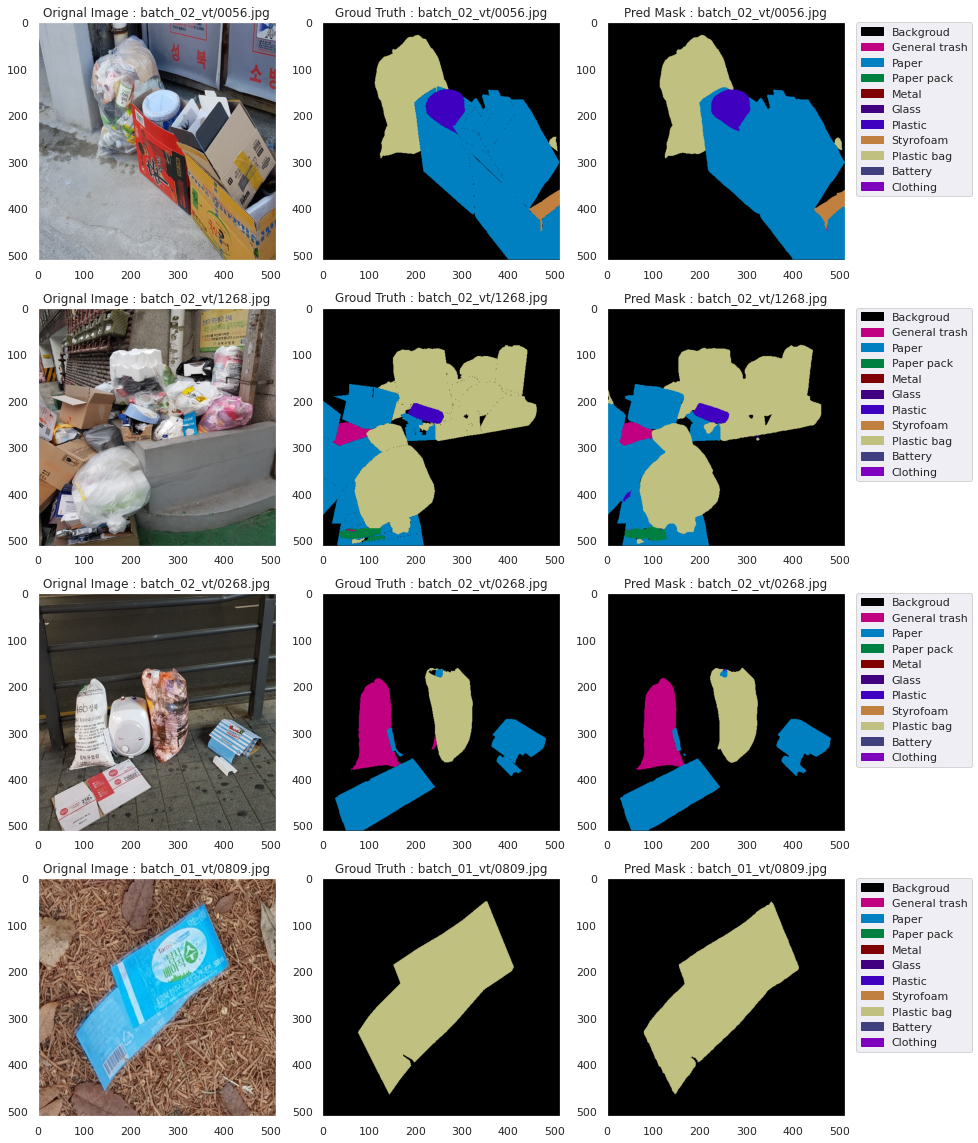

In [28]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

In [81]:
len(val_loader)

82

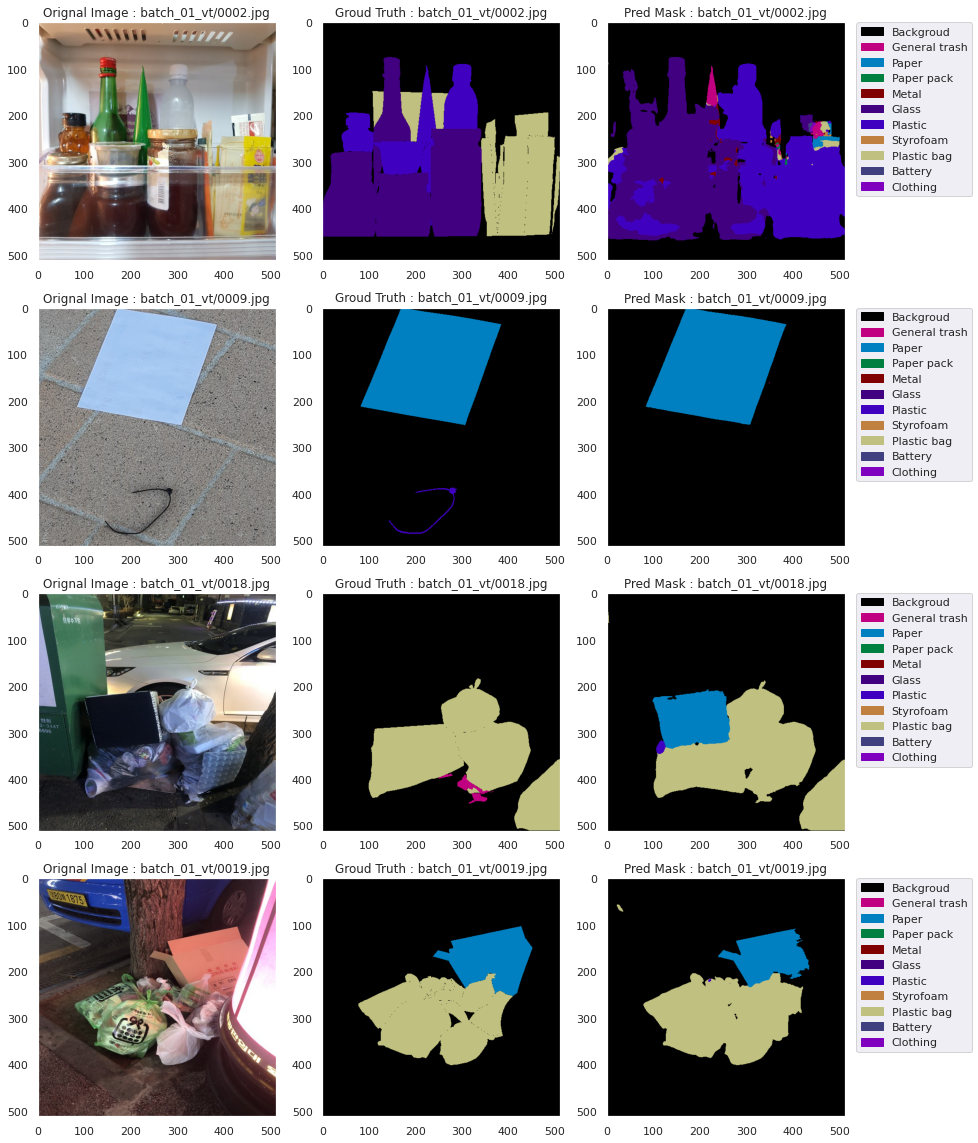

In [30]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

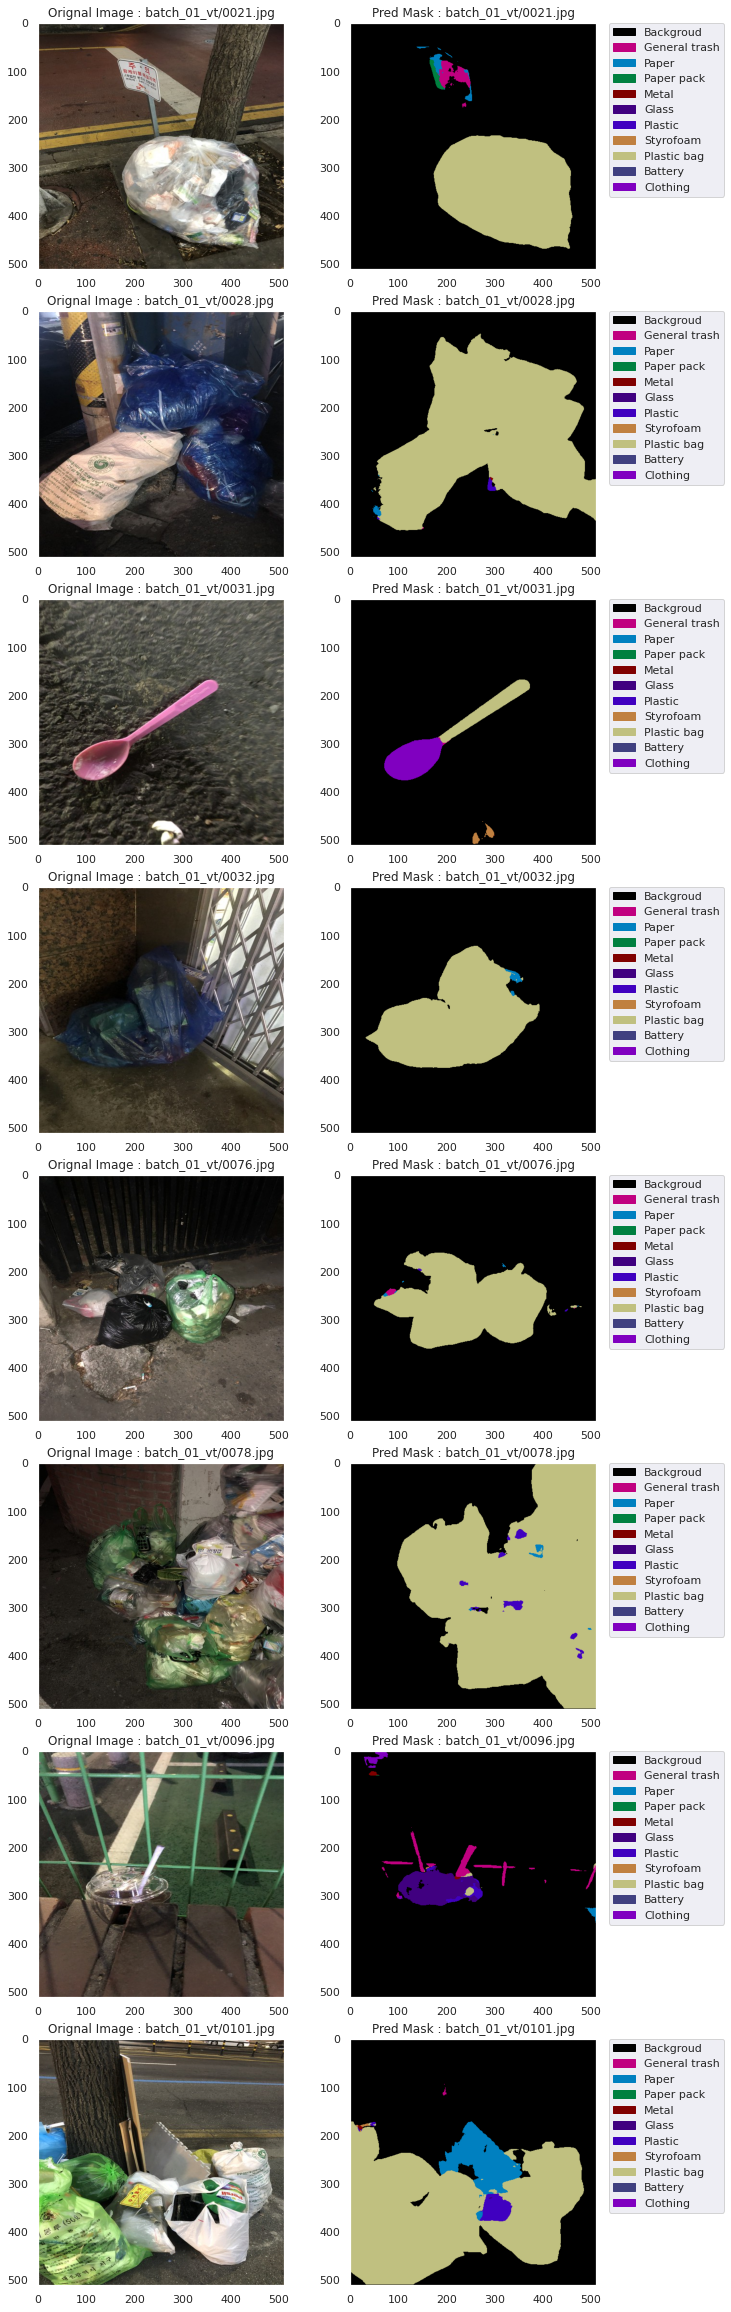

In [34]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [35]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))#['out']
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [36]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/hrnet_w48_Unet_submission.csv", index=False)

  0%|          | 0/103 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 103/103 [06:30<00:00,  3.19s/it]


End prediction.


In [99]:
submission.head()

image_id                                   PredictionString
0  batch_01_vt/0021.jpg  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1  batch_01_vt/0028.jpg  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2  batch_01_vt/0031.jpg  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3  batch_01_vt/0032.jpg  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4  batch_01_vt/0076.jpg  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...

In [100]:
submission.PredictionString[0]

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0